### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import statsmodels.formula.api as smf

from wordcloud import WordCloud
from src.scripts.article_to_country import *

from src.data.some_dataloader import *
from src.utils.plots import *
from src.utils.functions import *
from src.scripts.articles_clicks_links import click_count_in_paths


# <span style="color:#9689d6">ADA - Class Project</span>

## Team: Les Fraises TagADA
    Petit-Phar Oriane
    Friedrich Claire
    Gotti Bryan
    Théo Schifferli
    Jérémy Barghorn

# Table of contents : 

- [1. Are there cultural biases intrinsic to the Wikipedia graph?](#1-are-there-cultural-biases-intrinsic-to-the-wikipedia-graph)
    - [1.1 What countries are the most present in the Wikipedia graph?](#11-what-countries-are-the-most-present-in-the-wikipedia-graph)
    - [1.2 Are articles about some countries on average more connected than others?](#12-are-articles-about-some-countries-on-average-more-connected-than-others)
- [2. Are there cultural biases in the way players play Wikispeedia?](#2-are-there-cultural-biases-in-the-way-players-play-wikispeedia)
    - [2.1 What articles are most often clicked on? How does this relate to the country of the article?](#21-what-articles-are-most-often-clicked-on-how-does-this-relate-to-the-country-of-the-article)
    - [2.2 What paths do Wikispeedia players most follow? Are there "highway paths" that are very often used? Can this be linked to a cultural bias?](#22-what-paths-do-wikispeedia-players-most-follow-are-there-highway-paths-that-are-very-often-used-can-this-be-linked-to-a-cultural-bias)
    - [2.3 What articles are most likely to cause a player to stop the game? What makes those articles "dead ends"? What does this have to do with the country of these articles?](#23-what-articles-are-most-likely-to-cause-a-player-to-stop-the-game-what-makes-those-articles-dead-ends-what-does-this-have-to-do-with-the-country-of-these-articles)
- [3. How can we explain the players' biases?](#3-how-can-we-explain-the-players-biases)
    - [3.1 What is the distribution of countries among start / target articles for the Wikispeedia games? If it is not balanced, could this be an explanation?](#31-what-is-the-distribution-of-countries-among-start--target-articles-for-the-wikispeedia-games-if-it-is-not-balanced-could-this-be-an-explanation)
    - [3.2 Can we explain the variance in player's click counts with the number of links leading in and out of article?](#32-can-we-explain-the-variance-in-player's-click-counts-with-the-number-of-links-leading-in-and-out-of-article)
    - [3.3 How does the players' clicking behavior compare itself to PageRank? Are players significantly more biased than a random walk on the graph?](#33-how-does-the-players'-clicking-behavior-compare-itself-to-pagerank-are-players-significantly-more-biased-than-a-random-walk-on-the-graph)
    - [3.4 Is there something inherent to the way players play the game?](#34-is-there-something-inherent-to-the-way-players-play-the-game)


# 1. Are there cultural biases intrinsic to the Wikipedia graph?


## 1.1 What countries are the most present in the Wikipedia graph

First a naive approach is used by doing a text search and finding all the country string names inside the plaintext. This is done with help of a regex that matches all the countries in all the files. The results are then parsed in a table containing as index the article name and as columns all the possible countries on earth along with the number of occurences in the specific article. The following cell is doing this and should take arround 4min to run. Else just execute the next cell that will load the precomputed data.

In [3]:
# country_data = country_occurences_in_files()
# counts = filter_top_k(country_data, k=2, N=1)
# country_data.to_csv('data/country_data.csv')

In [4]:
country_data = pd.read_csv('data/country_data.csv', index_col=0)

This table is then used in order to find the top K countries inside an article with at least N occurences

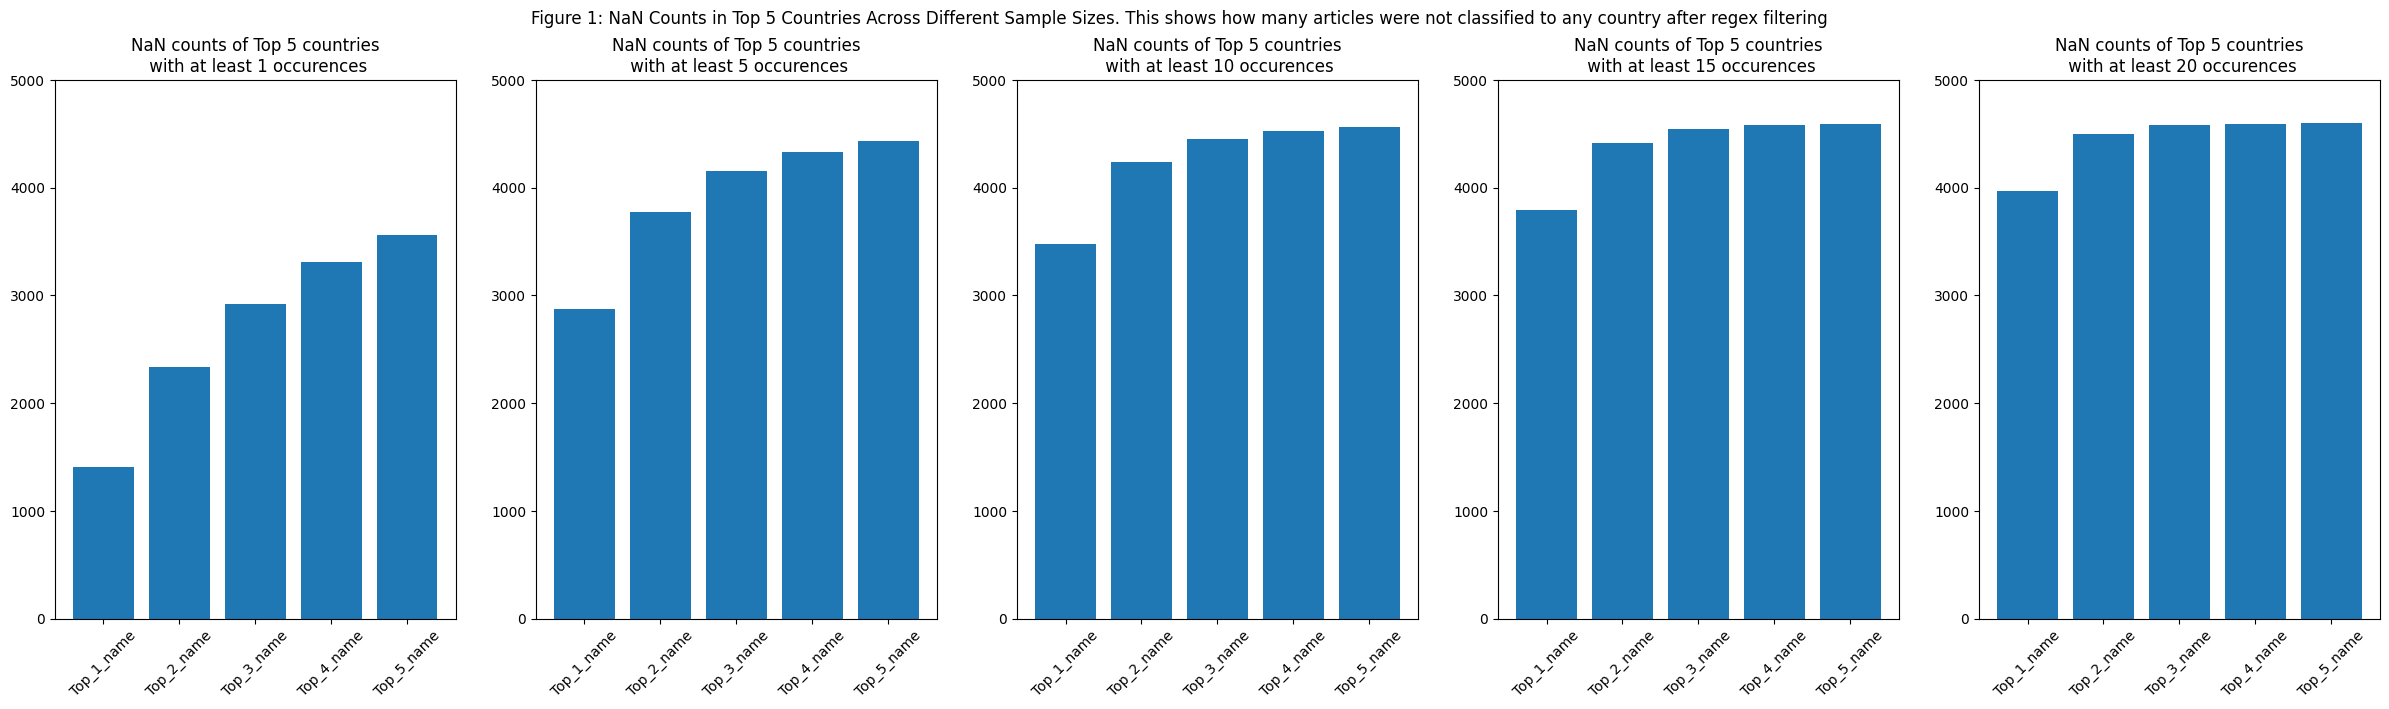

In [5]:
N_samples = [1, 5, 10, 15, 20]
K = 5

fig, axs = plt.subplots(1, len(N_samples), figsize=(30, 7))

i = 0
for j, N in enumerate(N_samples):
    counts = filter_top_k(country_data, k=K, N=N)
    df_cleaned = counts.iloc[:, :K]
    df_stat = df_cleaned.isna().sum()
    axs[j].bar(df_stat.index, df_stat)
    axs[j].set_title(f"NaN counts of Top {K} countries\n with at least {N} occurences")
    axs[j].set_ylim(0, 5000)
    axs[j].xaxis.set_tick_params(rotation=45)
fig.suptitle("Figure 1: NaN Counts in Top 5 Countries Across Different Sample Sizes. This shows how many articles were not classified to any country after regex filtering")
plt.show()

From the previous cell it was clear that in order to classify the maximum number of articles we needed to pick a small number of occurences (N = 1) in order to avoid discarding more than half of the articles. 

In [6]:
counts = filter_top_k(country_data, k=2, N=1)
nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")


Number of articles with no countries before completion with llama: 1412


This approach resulted in 1412 articles having no country assigned to them. By going manually through them it can be seen that as a human some articles can be further classified to countries even if the country name is not explicetly mentionned in the text.

For example, the article 4-2-0 is about a railway in the United States, in Chicago, but does not contain the substring "United States". Yet, it can clearly be associated to a country (USA) and this is what the LLM successfully achieved. 

### Further classifying articles to countires with the help of small llm's

Two LLM's were tested (Qwen and Llama) and only Llama (a Meta LLM) was retained in order to assign the missing articles to countries. For this to be done the LLM was downloaded locally and used for inference on the plaintext articles. 

The format of the prompt used to let the model classify articles to countries was : 
```
<system_prompt_begin>
You will be given textual articles. For each article provide single and unique country to which the article is related and should be classified to. Provide the answer in the form : <country>. If there is no country related to the article, please write 'None'. If the location is not on earth, please write 'None'. You must be 100\% sure this is a question of life or death.
<system_prompt_end>

<user_prompt_begin>
plaintext article
<user_prompt_end>
```

Run this by executing the following cell : 
(Note : It was already preprocessed so this can also be skipped and the  ```data/country_occurences.csv``` can be loaded)

In [7]:
# !python article_to_country.py

In [8]:
refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with llama: {len(nan_df)}")

Number of articles with no countries after completion with llama: 887


This approach allowed to classify 1412 - 887 = 525 new articles having a country assigned to them. In the cell below it can be seen which articles were classified with help of the LLM (the ones having a "Top_1_count" of 0 meaning 0 occurences of this exact substring in the text but still classified as this country by the llm because it was able to extract a country based on the abstract content of the article)

In [9]:
refined_data[refined_data["Top_1_count"] == 0].head(10)

Top_1_name Top_2_name  Top_1_count  \
1980_eruption_of_Mount_St._Helens   united states        NaN          0.0   
4-2-0                               united states        NaN          0.0   
4-4-0                               united states        NaN          0.0   
4-6-0                               united states        NaN          0.0   
4th_century                                 india        NaN          0.0   
6-2-0                               united states        NaN          0.0   
8th_century                        united kingdom        NaN          0.0   
Aardvark                             south africa        NaN          0.0   
Abbadid                                     spain        NaN          0.0   
Abstract_art                               russia        NaN          0.0   

                                   Top_2_count  
1980_eruption_of_Mount_St._Helens          NaN  
4-2-0                                      NaN  
4-4-0                                      NaN  
4-6-0                                      NaN  
4th_century                                NaN  
6-2-0                                      NaN  
8th_century                                NaN  
Aardvark                                   NaN  
Abbadid                                    NaN  
Abstract_art                               NaN

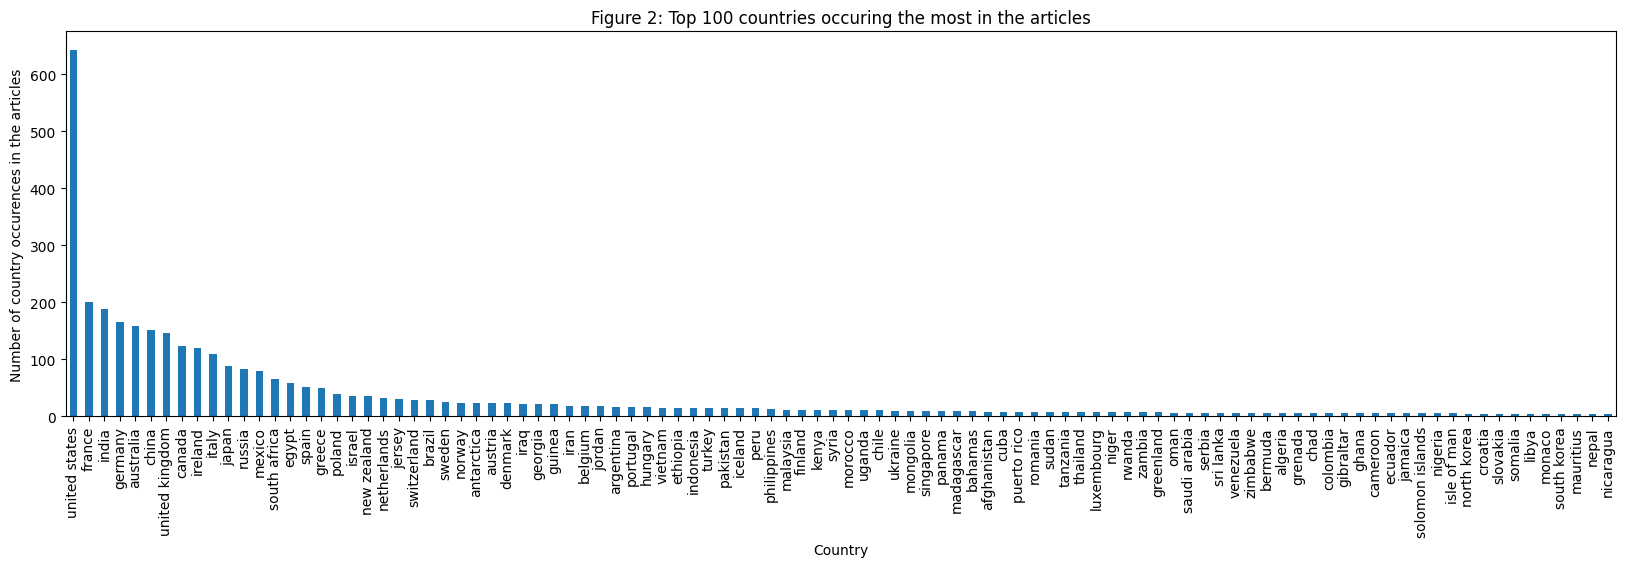

In [10]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Figure 2: Top 100 countries occuring the most in the articles")
plt.show()

On the plot above, we can note that the country that is the most represented in the Wikipedia graph is with no suprise the United States. It occures 3 times more than the second most occurring country (France) which is a very large lead. This is the first evidence showing that the Wikipedia data is biased towards USA data and this observation will have to be taken into account when doing further analyses. A second observation that we can make on this plot is that the distribution of country occurrences is skewed towrads the right, meaning that most countries do not occur often and few occur often. There are around 10 "country leadres" in the Wikipedia graph (USA, France, India, Germany, AUstralia, China, UK, Canada, Ireland, Italy, Japan, Russia). These "leaders" coincide with the countries leading the real world. This shows that Wikipedia contains more articles on topics ratached to countries with real-world influence than to smaller, less influencing countries. 

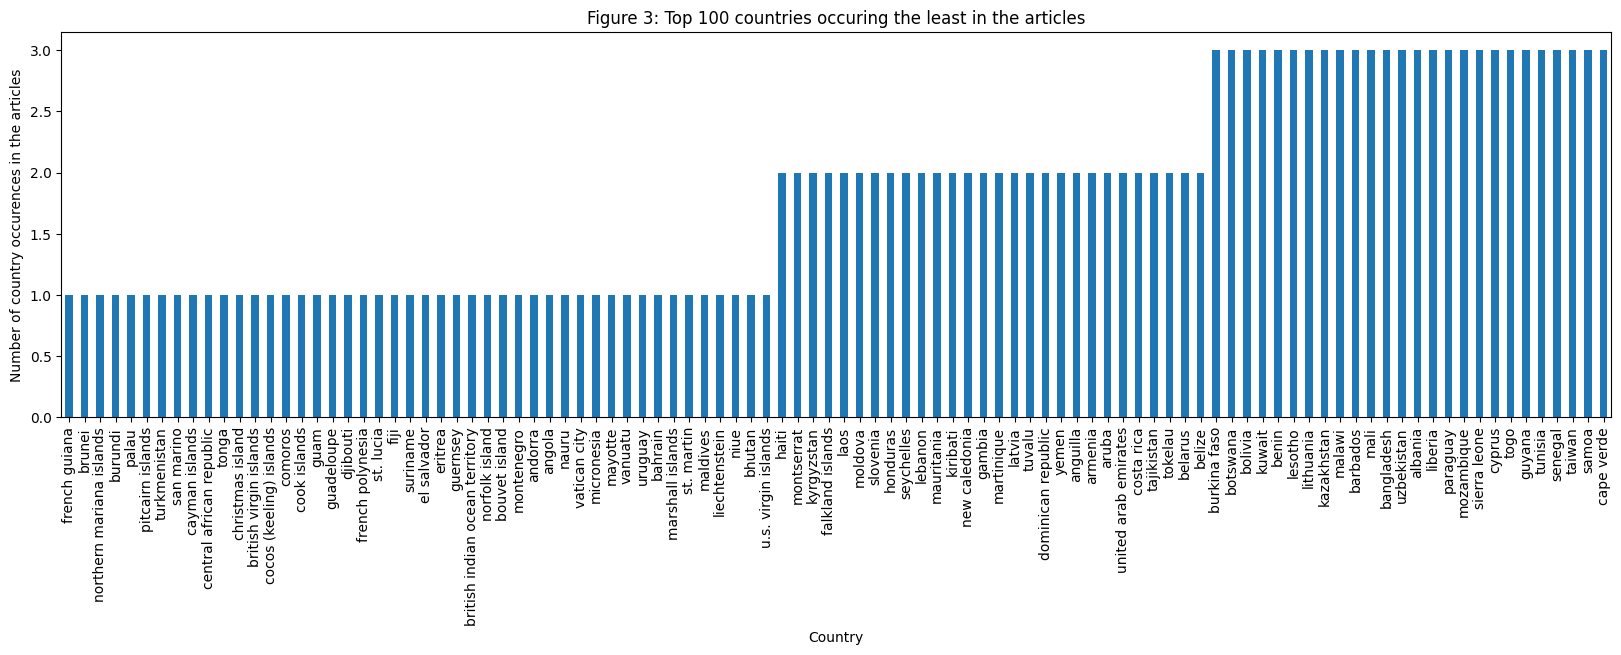

In [11]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=True).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Figure 3: Top 100 countries occuring the least in the articles")
plt.show()

On this plot we see that the countries that occur the least in the Wikipedia data are small countries or islands that have less influence on world dymanics nowadays. 

## 1.2 Are articles about some countries on average more connected than others


Now that we have seen which articles are associated with which countries, we will investigate the relations between the country of an article compared to the countries it is connected to in it's outgoing links. 

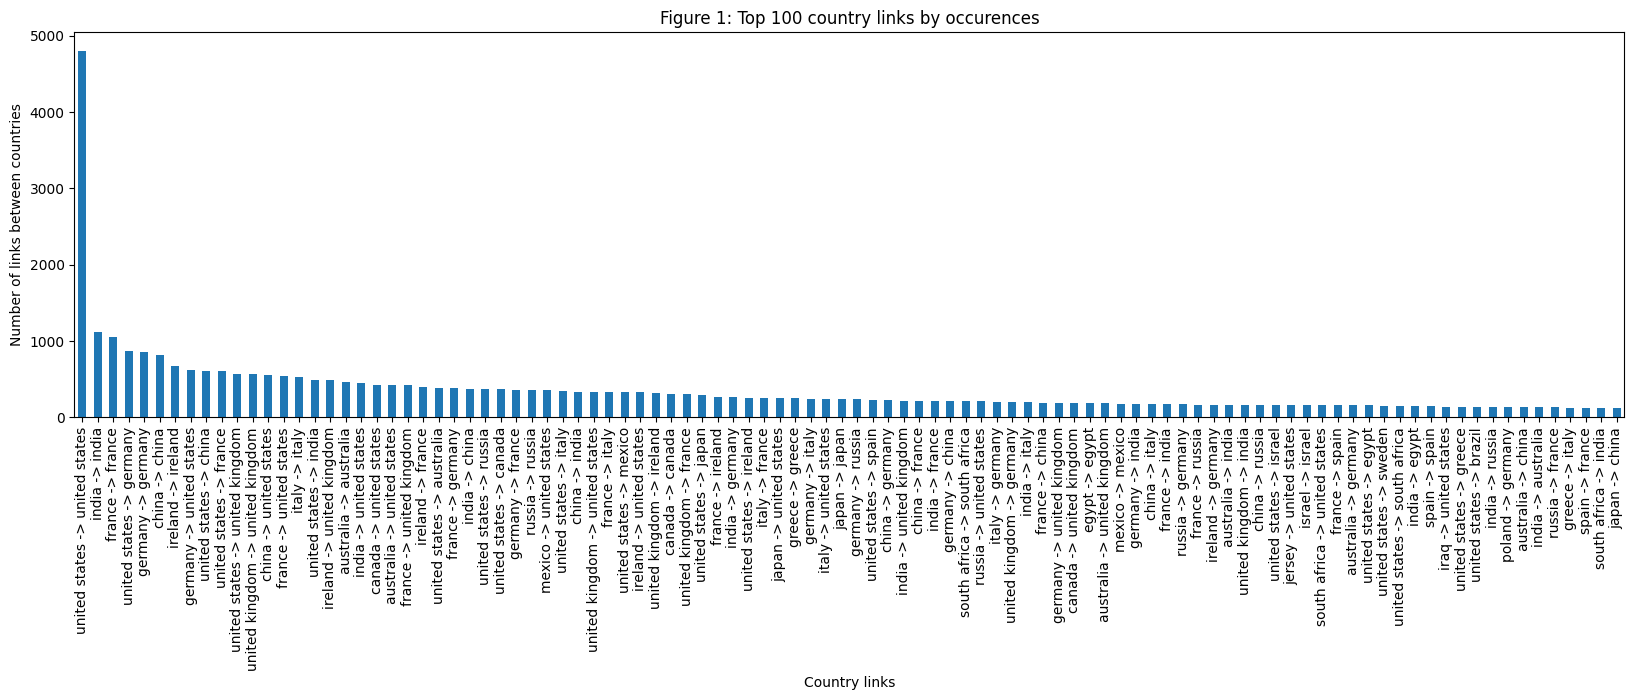

In [12]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
plot_country_to_country(country_clicks)

It can be seen that articles of one country are always strongly interconnected. In the sense that once the user is inside articles assigned to a specific country, they have larger chances to stay in articles of the sam country by clicking on links to navigate to other articles. This can be observed by the fact that there are many connections of the form "france" -> "france" that are occuring and have higher counts than connections "france" -> "other country"

# 2. Are there cultural biases in the way players play Wikispeedia?


Above we have focused on the distribution of different countries in the Wikipedia data. Now we will have a closer look into the **Wikispeedia data**! 

The data that will be used for the rest of this notebook can be created by uncommenting the cell below (Note: we already ran it for you so the data in ```data/country_clicks_links.csv``` can be directly loaded!)

In [13]:
#!python articles_clicks_links.py

The dataframe containsthe following columns: 

- **Top_1_name** = name of the country that occurs the most in the article
- **Top_2_name** = name of the country that occurs the second most in the article
- **Top_1_count** = number of times that the Top1 country occurs
- **Top_2_count** = number of times that the Top2 country occurs
- **click_count** = number of times the article occurs in the clicking paths of the Wikispeedia game
- **num_links_in** = number of articles that lead to article of interest 
- **name_links_in** = name of the artciles that lead to article of interest
- **num_links_out** = number of links in the article of interest, leading out of the article
- **name_links_out** = name of the articles that are references by the article of interest 

Each row is an article. 

In [14]:
df_country_clicks_links = pd.read_csv('data/country_clicks_links.csv', index_col=0)
df_country_clicks_links.shape

(4604, 9)

## 2.1 What articles are most often clicked on? How does this relate to the country of the article?

The first thing to do is to look at the *usage* of articles by players in the Wikispeedia game, so the number of times an article is clicked (e.g. number of article occurrences in the merged finished and unfinished paths).

In [15]:
df_country_clicks_links_sorted = df_country_clicks_links.sort_values(by='click_count', ascending=False)

### Most used articles 

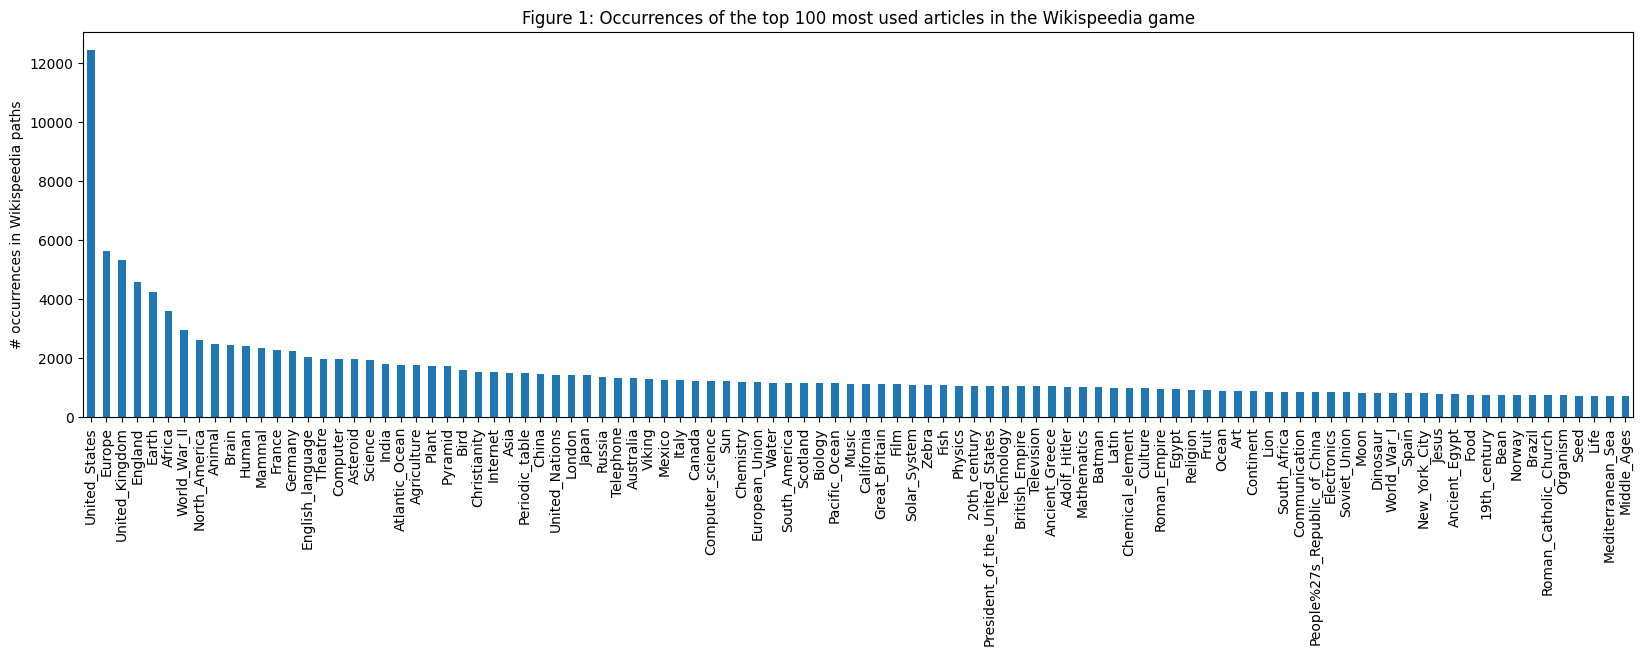

In [16]:
# plot the most used articles 
df_country_clicks_links_sorted['click_count'].head(100).plot(kind='bar', stacked=True, figsize=(20, 5))

plt.xticks(ticks=range(len(df_country_clicks_links_sorted.head(100))), labels=df_country_clicks_links_sorted.index.tolist()[0:100], fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')

plt.title("Figure 1: Occurrences of the top 100 most used articles in the Wikispeedia game")
plt.show()

We see that the most used article is United_States. This article is much more used that all other articles which have roughly the same click number. This is evidence showing that United_States is a "hub" article. 

**Which countries are represented within the most used articles?**

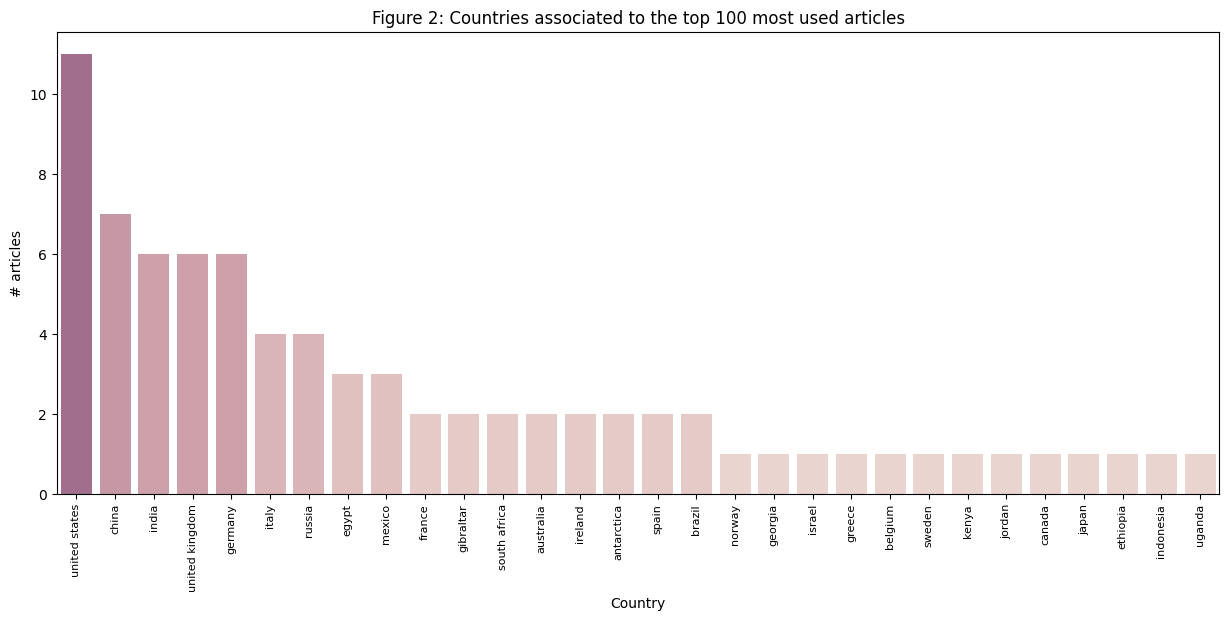

In [17]:
df_top_1_article_count_per_country = pd.DataFrame(df_country_clicks_links_sorted['Top_1_name'].head(100).value_counts(dropna=False))

plt.figure(figsize=(15, 6))
sns.barplot(x=df_top_1_article_count_per_country.index, y=df_top_1_article_count_per_country['count'], hue=df_top_1_article_count_per_country['count'], legend=False)
plt.xticks(fontsize=8, rotation=90)

plt.ylabel('# articles')
plt.xlabel("Country")
plt.title("Figure 2: Countries associated to the top 100 most used articles")

plt.show()

We see that the top 100 most used articles belong mostly to the United States, United Kingdom, China, India and Germany. This relates to the most occuring countries (Figure 2 in part 1.1)

In [18]:
df_top_1_article_count_per_country[df_top_1_article_count_per_country.index.isna()]

count
Top_1_name       
NaN            21

Among the Top 100 articles, 21 are belonging to no country. 

We see that the United States are the most represented in the 100 most used articles (11/100 most used articles belong to USA). But, the articles associated to this country have a huge variance in click count. Indeed, the article United_states has 12449 while New_York_City has 793. This strong differences in click counts explains why the United States appear as the most clicked country in the plot in Figure 4

**Which countries are most clicked?**

In [19]:
# count number of clicks per country
country_clicks = df_country_clicks_links.groupby('Top_1_name')['click_count'].sum().reset_index()
sorted_country_clicks = country_clicks.sort_values(by='click_count', ascending=False)

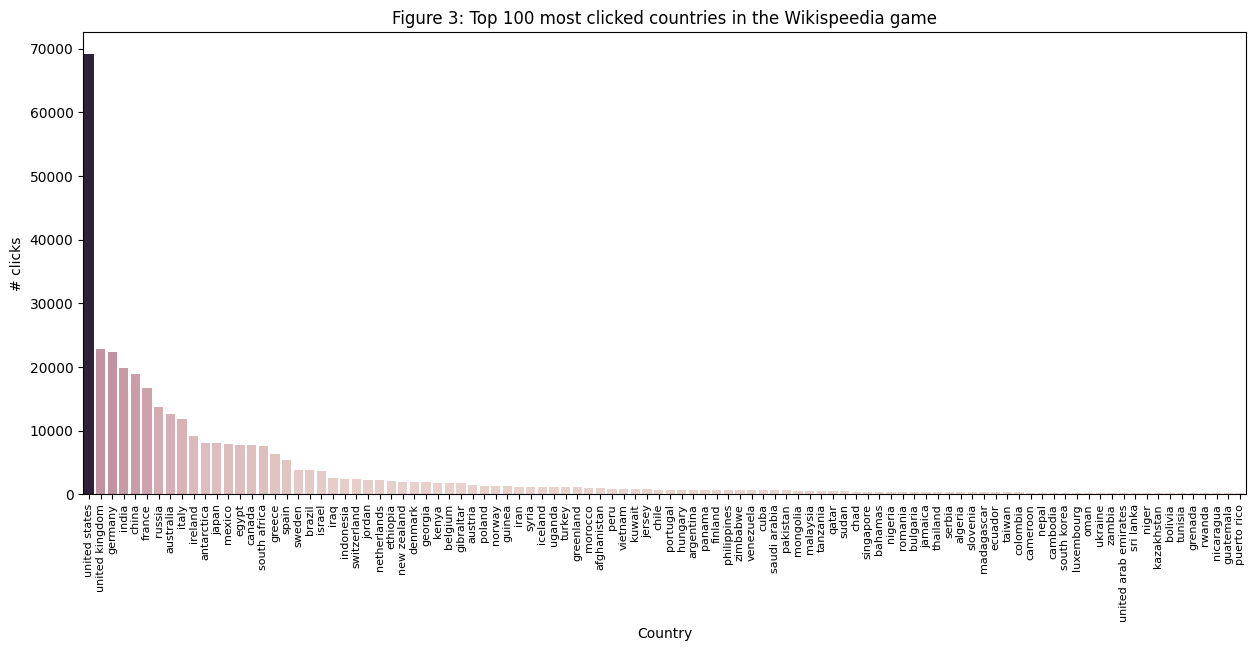

In [20]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=sorted_country_clicks.head(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.head(100))), labels=sorted_country_clicks['Top_1_name'].head(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 3: Top 100 most clicked countries in the Wikispeedia game")
plt.show()

### Least used articles

In [21]:
# find articles that are never clicked on
never_used_articles = df_country_clicks_links[df_country_clicks_links['click_count'] == 0]
print(f'there are {round(len(never_used_articles)/len(df_country_clicks_links) * 100, 2)}% of articles that are never clicked on in the game')

there are 9.17% of articles that are never clicked on in the game


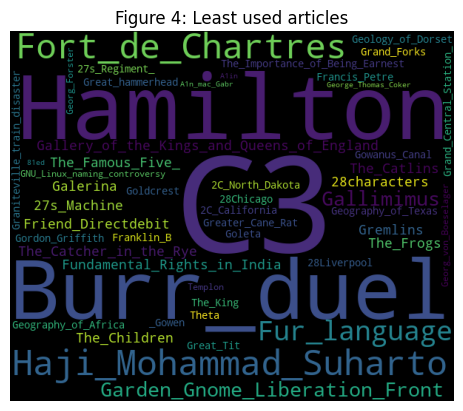

In [22]:
# Generate the word cloud for the least used articles
unique_string_least = (" ").join(list(df_country_clicks_links_sorted.index.tolist()[-40:]))
wordcloud_least = WordCloud(width=600, height=500).generate(unique_string_least)

# Plot the word cloud for the least used articles
plt.imshow(wordcloud_least)
plt.title("Figure 4: Least used articles")
plt.axis("off")
plt.show()

The least occurring articles are never clicked and are on strange topics that are not very well known to common knowledge. 

**Which countries are most represented within the least used articles?**

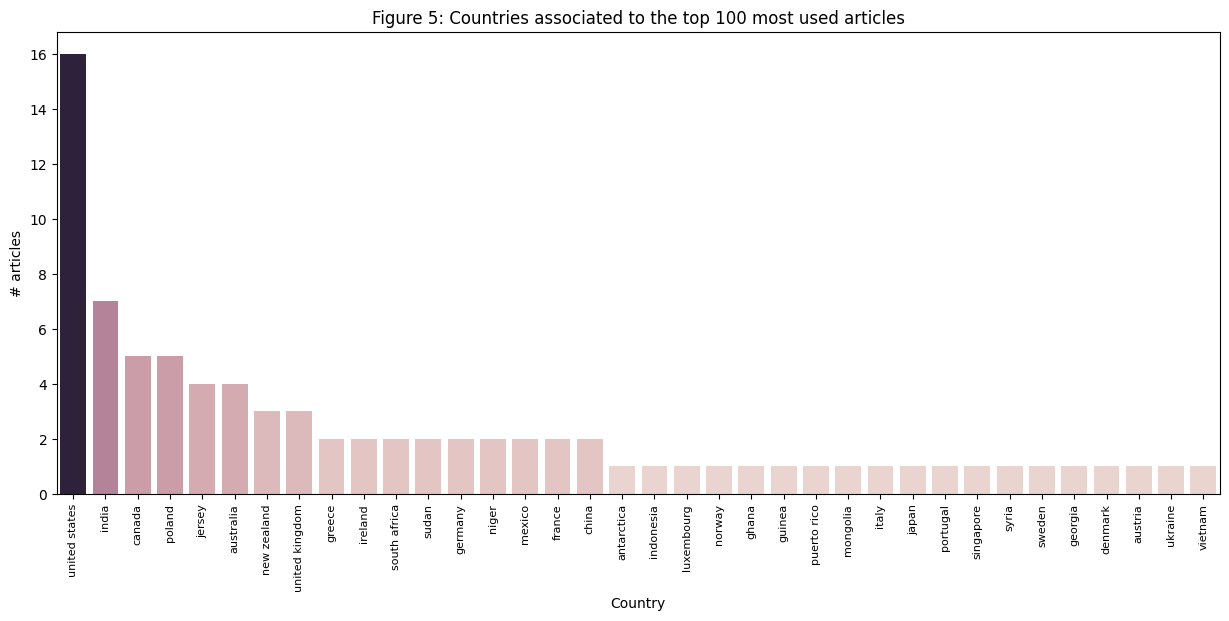

In [23]:
df_least_article_count_per_country = pd.DataFrame(df_country_clicks_links_sorted['Top_1_name'].tail(100).value_counts(dropna=False))

plt.figure(figsize=(15, 6))
sns.barplot(x=df_least_article_count_per_country.index, y=df_least_article_count_per_country['count'], hue=df_least_article_count_per_country['count'], legend=False)
plt.xticks(fontsize=8, rotation=90)

plt.ylabel('# articles')
plt.xlabel("Country")
plt.title("Figure 5: Countries associated to the top 100 most used articles")

plt.show()

In [24]:
df_least_article_count_per_country[df_least_article_count_per_country.index.isna()]

count
Top_1_name       
NaN            16

Among the 100 least used articles, 16 are belonging to no country. 

We see that also among the 100 least used articles, the United States are the leading country, again by far. This can be explained by the fact that there are far more articles in general that are associated to the United States. So this country dominates the most and the least used articles. 

**What are the least clicked countries?**

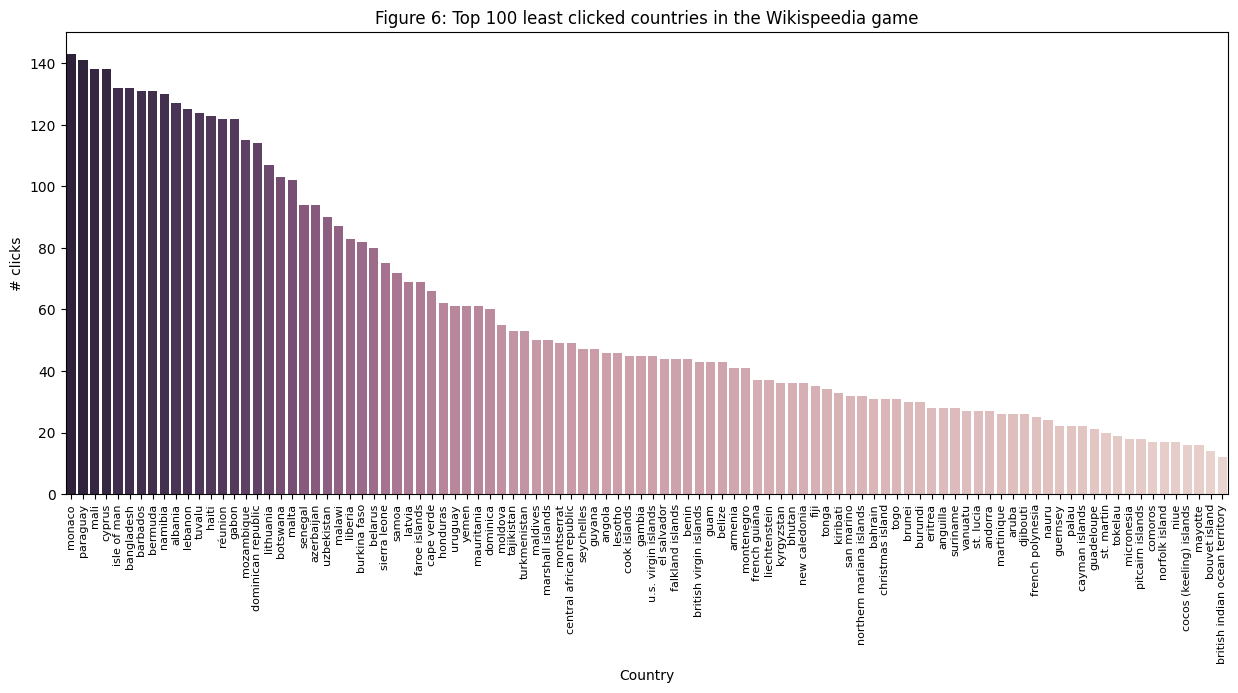

In [25]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=sorted_country_clicks.tail(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.tail(100))), labels=sorted_country_clicks['Top_1_name'].tail(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 6: Top 100 least clicked countries in the Wikispeedia game")
plt.show()

### Caveat & scaling: a more advanced approach to investigate article usage

The plots above are the result of a very naive analysis. We simply counted the number of times that and article/country is clicked. But we have shown in part 1 that the distribution of countries in the Wikipedia data is not at all uniform. There are at least 3 times more articles that are associated to the United States than articles associated to any other country. It is thus logical that people click more on countries that are more present. This does not direclty show a bias of the players towards certain countries but simply shows that the Wikipedia graph is in itself biased towards some countries and players simply navigate through this biases graph. This intrisic bias of the graph will be further analyzed in part 3.

In order to investigate the player's biases towards countries in their clicking behavior, we have to scale the number of clicks per country by the number of occurrences of those countries in the Wikipedia data. 

In [26]:
# scale the number of clicks by the number of occurrences of the country
top_1_counts = df_country_clicks_links['Top_1_name'].value_counts()
country_clicks['occurrences'] = country_clicks['Top_1_name'].map(top_1_counts)
country_clicks["scaled_click_count"] = country_clicks["click_count"] / country_clicks["occurrences"]
sorted_country_clicks = country_clicks.sort_values(by='click_count', ascending=False)

**Which countries are most clicked after scaling?**

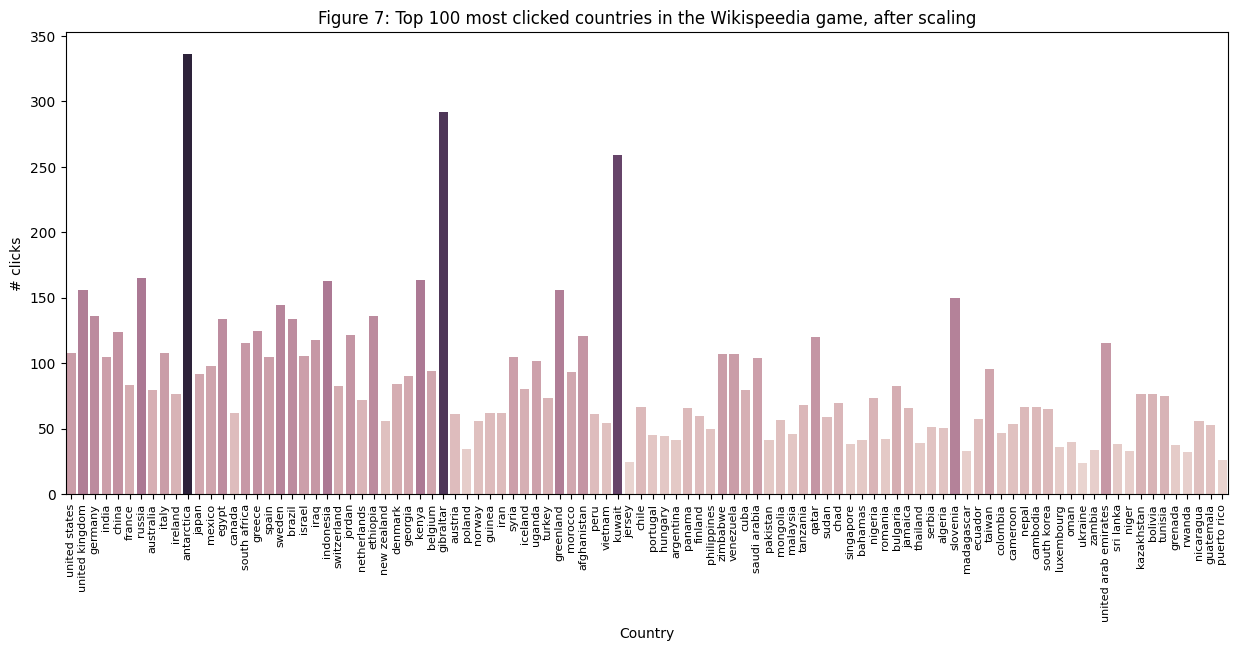

In [27]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="scaled_click_count", hue='scaled_click_count', data=sorted_country_clicks.head(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.head(100))), labels=sorted_country_clicks['Top_1_name'].head(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 7: Top 100 most clicked countries in the Wikispeedia game, after scaling")
plt.show()

We see that after scaling, the number of clicks on the United States dramatically decreases. The 3 countries that are most clicked on are now Antarctica, Gibraltar and Kuwait. 

**Which countries are least clicked after scaling?**

In [28]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="scaled_click_count", hue='scaled_click_count', data=sorted_country_clicks.tail(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.tail(100))), labels=sorted_country_clicks['Top_1_name'].tail(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 8: Top 100 least clicked countries in the Wikispeedia game, after scaling")
plt.show()

The distribution of the least clicked countries after scaling does not change so drastically. 

## 2.2 What paths do Wikispeedia players most follow? Are there "highway paths" that are very often used? Can this be linked to a cultural bias?


Now that we have investigated the clicking behavior of Wikispeedia players, we can focus on another metric approximating their behavior: the intermediate paths between articles in game paths. We are not only interested in the first and last articles of a game path, but also in intermediate ones to investigate players behaviours. More specifically, we want to know whether there exist some common paths that are intensively used by players.

The first thing to do after loading the data is to extract each game path (from paths_finished.csv and paths_unfinished.csv) as a list. Then, we find every pair of articles within those list and we count the number of time that each pair appears. A pair of article is considered as a 1-unit long path and we want to investigate which of those paths are the most used. 
To get more representative results, the counts are normalized by dividing by the total number of 1-unit long paths found in paths_finished.csv and paths_unfinished.csv respectively.

In [29]:
finished_paths = load_path_finished_dataframe()
finished_paths_divided = finished_paths["path"].apply(lambda row: row.split(';'))

unfinished_paths = load_path_unfinished_distance_dataframe()
unfinished_paths_divided = unfinished_paths["path"].apply(lambda row: row.split(';'))

In [30]:
# Focus on finished paths first
all_pairs_finished = find_pairs(finished_paths_divided)
all_pairs_finished_df = pd.DataFrame({'1-unit long path': all_pairs_finished})

In [31]:
# Then, focus on unfinished paths
all_pairs_unfinished = find_pairs(unfinished_paths_divided)
all_pairs_unfinished_df = pd.DataFrame({'1-unit long path': all_pairs_unfinished})

In [32]:
# Combine finished and unfinished paths
all_pairs_merged = pd.concat([all_pairs_finished_df, all_pairs_unfinished_df])

In [33]:
# Normalisation (divide by the total number of pair)
all_pairs_finished_normalized = all_pairs_finished_df.value_counts() / all_pairs_finished_df.value_counts().sum()
all_pairs_unfinished_normalized = all_pairs_unfinished_df.value_counts() / all_pairs_unfinished_df.value_counts().sum()
all_pairs_merged_normalized = all_pairs_merged.value_counts() / all_pairs_merged.value_counts().sum()

For visualisation purposes, we plot only the top 20 of 1-unit long paths. We decided to first plot the paths from paths_finished.csv and paths_unfinished.csv, and then combine the two results. 

In [34]:
# Select the top 20 of 1-unit long paths for visualisation 
top20_finished = all_pairs_finished_normalized.head(20)
top20_unfinished = all_pairs_unfinished_normalized.head(20)
top20_merged = all_pairs_merged_normalized.head(20)

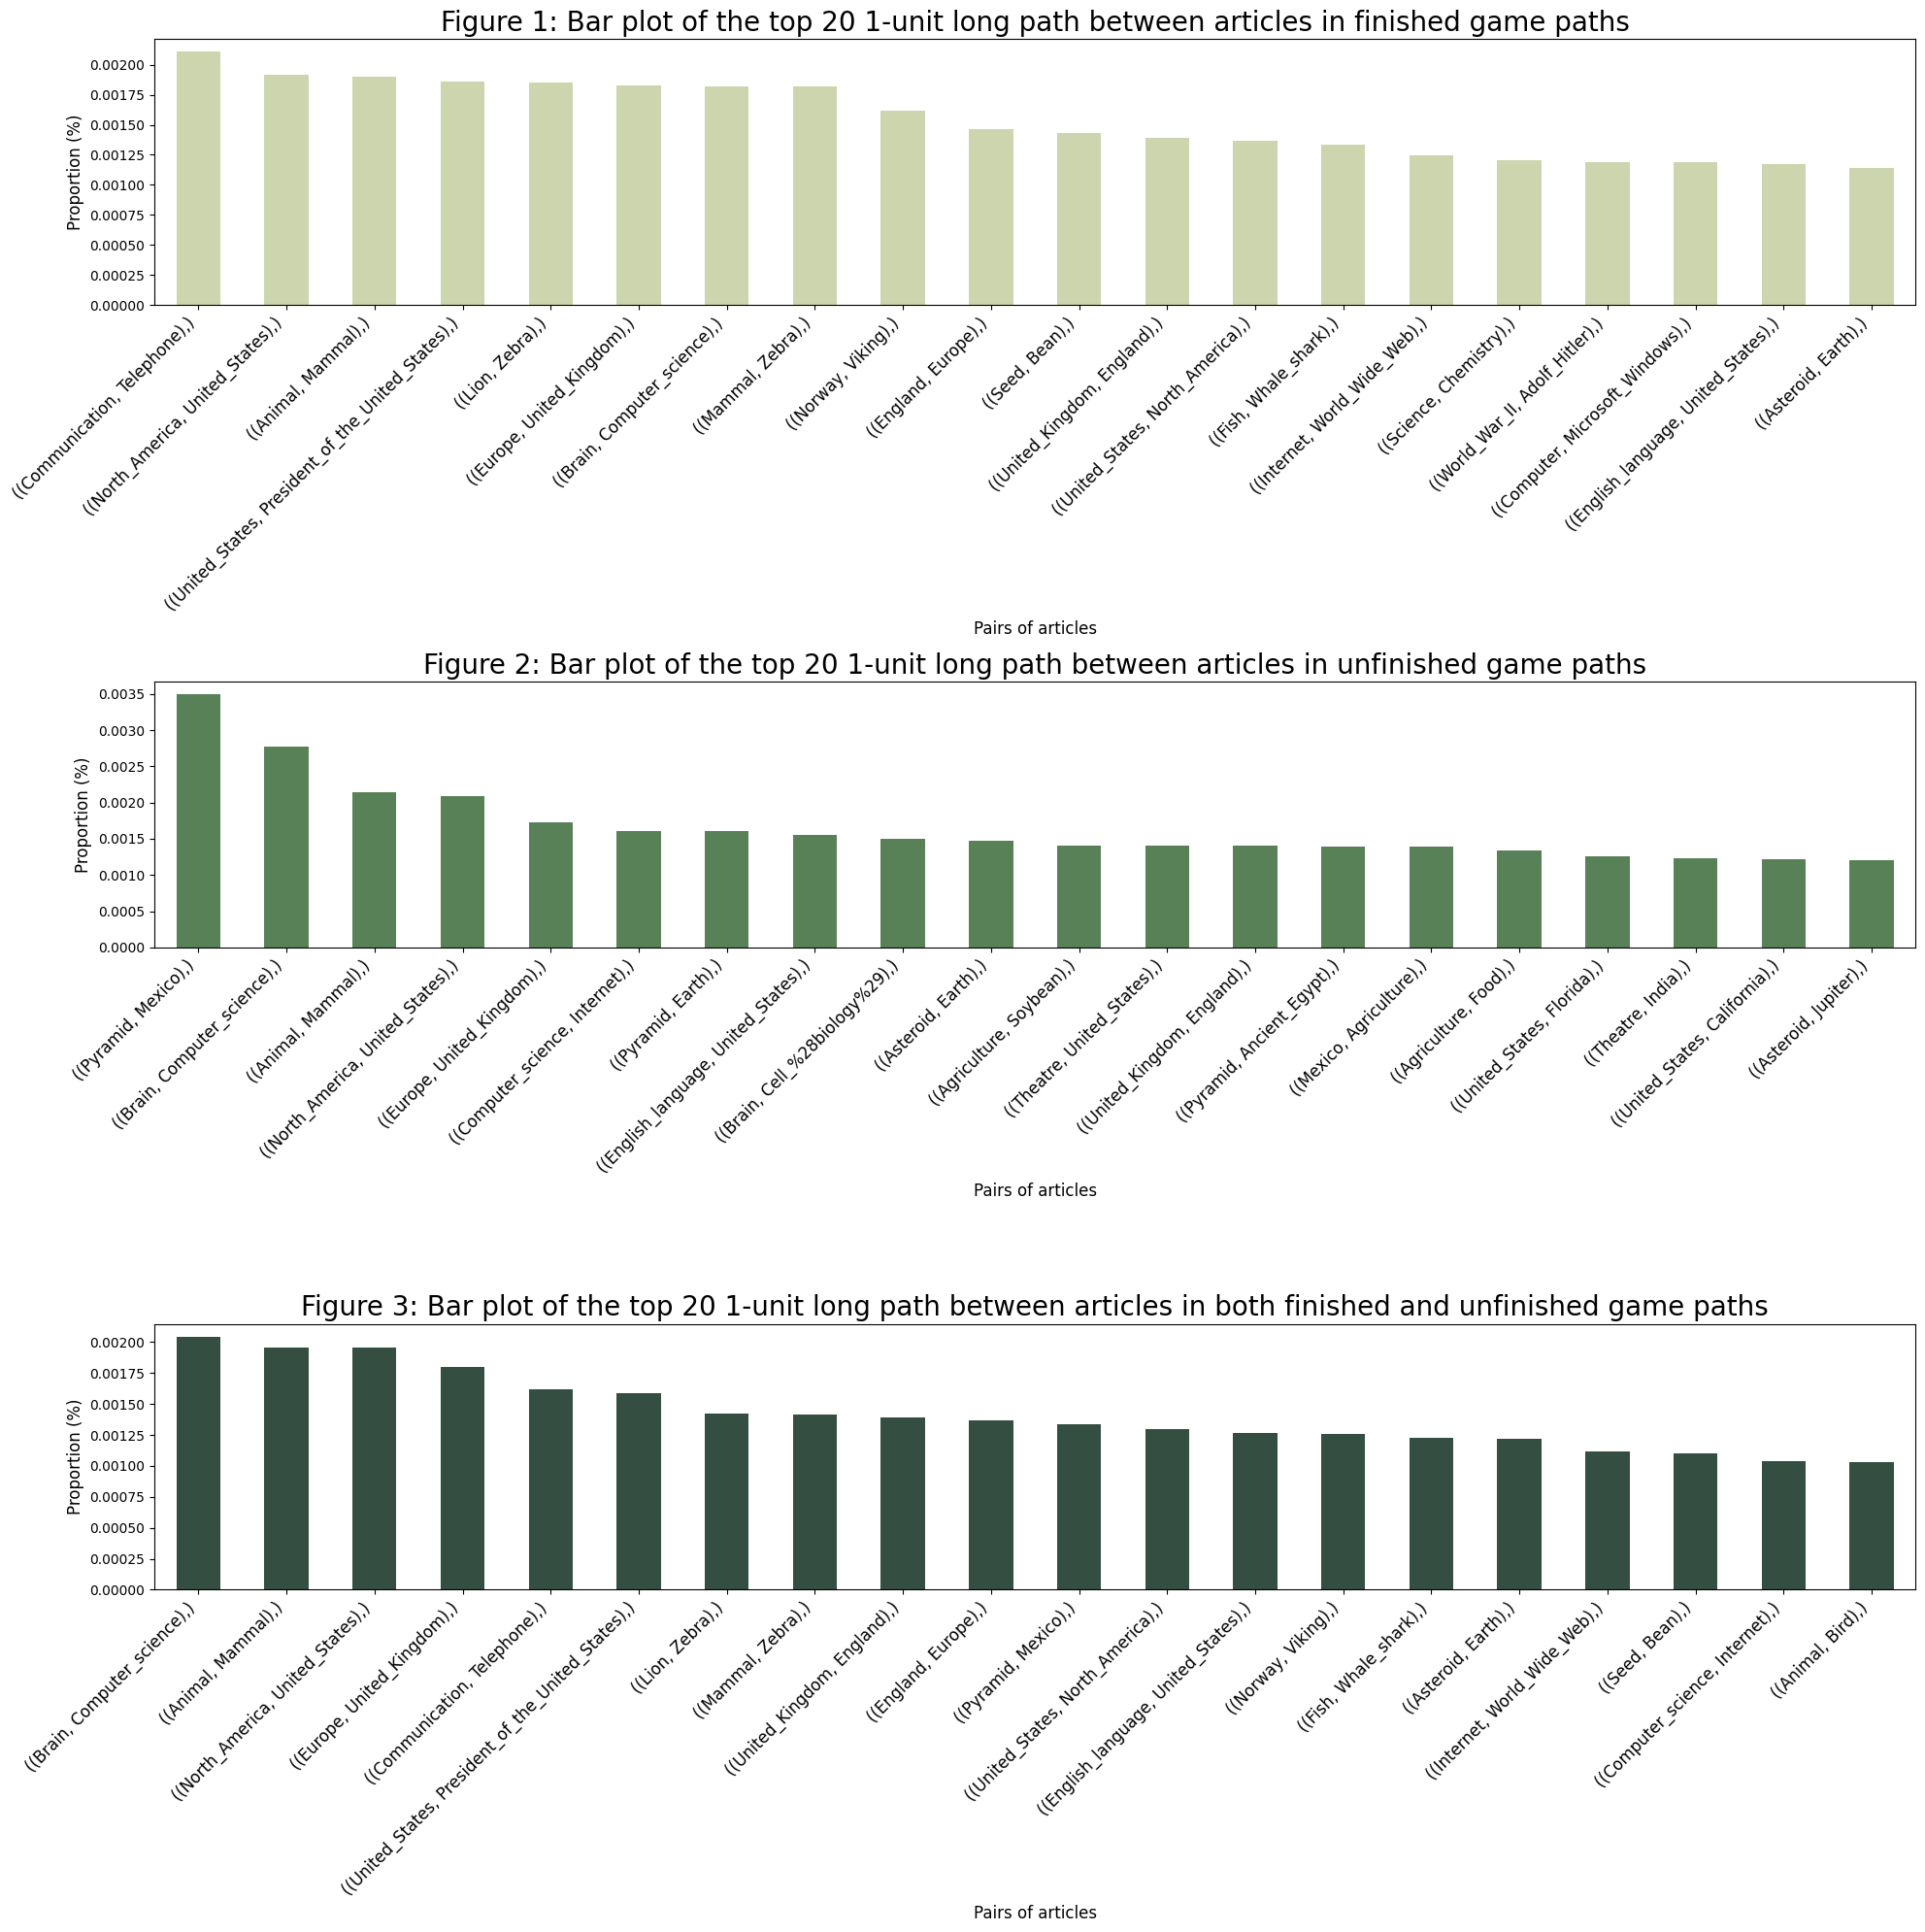

In [35]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
top20_finished.plot(kind='bar', width= 0.5, color='#ccd5ae')
plt.title('Figure 1: Bar plot of the top 20 1-unit long path between articles in finished game paths', fontsize=20)
plt.xlabel('Pairs of articles', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45,ha='right',fontsize=12)

plt.subplot(3, 1, 2)
top20_unfinished.plot(kind='bar', width= 0.5, color='#588157')
plt.title('Figure 2: Bar plot of the top 20 1-unit long path between articles in unfinished game paths', fontsize=20)
plt.xlabel('Pairs of articles', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45,ha='right',fontsize=12)

plt.subplot(3, 1, 3)
top20_merged.plot(kind='bar', width= 0.5, color='#344e41')
plt.title('Figure 3: Bar plot of the top 20 1-unit long path between articles in both finished and unfinished game paths', fontsize=20)
plt.xlabel('Pairs of articles', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45,ha='right',fontsize=12)

plt.tight_layout()
plt.show()

This plot allows us to compare the 1-unit long paths between paths_finished.csv and paths_unifished.csv. Interestingly, some paths like Communication -> Telephone or Mammal -> Zebra only appear in the top 20 obtained from paths_finished.csv while other paths like Pyramid -> Mexico or Europe -> United Kingdom only appear in the top 20 obtained from paths_unfinished.csv. This could indicate that a difference of the player's behavior might have an influence on whether they win the game or not.

However, to identify "highway paths", we find it more relevant to combine counts from both datasets. The third subplot highlights paths that are most often taken by players. However, those normalized results indicate that even the top 1 path correponds to only 0.2% which is almost nothing.

Now, let's associate each pair of articles with their Top1 country.

In [36]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)

In [37]:
# Divide pairs into 2 columns 'From' and 'To' > Split
all_pairs_countries = all_pairs_merged.copy()
all_pairs_countries['Article_from'] = all_pairs_merged['1-unit long path'].apply(lambda row: row[0].split(',')[0] if isinstance(row[0], str) else row)
all_pairs_countries['Article_to'] = all_pairs_merged['1-unit long path'].apply(lambda row: row[1].split(',')[0] if isinstance(row[0], str) else row)

# Associate each article from columns 'From' and 'To' to their Top_1_name country
all_pairs_countries['Top1_country_From'] = all_pairs_countries['Article_from'].map(country_clicks['Top_1_name'])
all_pairs_countries['Top1_country_To'] = all_pairs_countries['Article_to'].map(country_clicks['Top_1_name'])

# Create a column with a pair of countries
all_pairs_countries['1-unit long path - COUNTRIES'] = all_pairs_countries['Top1_country_From'] + "-> " + all_pairs_countries['Top1_country_To']

In [38]:
# Normalize and select top 40
all_pairs_countries_normalized = all_pairs_countries["1-unit long path - COUNTRIES"].value_counts() / all_pairs_countries["1-unit long path - COUNTRIES"].value_counts().sum()
top40_countries = all_pairs_countries_normalized.head(40)

In [39]:
plt.figure(figsize=(20, 5))

top40_countries.plot(kind='bar', width= 0.5, color='#4895ef')
plt.title('Figure 4: Bar plot of the top 40 of 1-unit long path between countries', fontsize=20)
plt.xlabel('Pairs of countries', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45,ha='right',fontsize=12)

plt.show()

There's a clear dominance of paths from United States to United States, those paths corresponds to approximately 9% of the total number of paths taken by players. Among the top 40 paths, we can also see that there are a lot of paths linking a country to itself (ex: Germany -> Germany, United Kingdom -> United Kingdom, etc.) which is expected as we previously saw that articles of one country are strongly interconnected.

Interestingly, there are also paths between two different countries. Some of them are neighbour countries like United Kingdom and Ireland but most paths linking 2 different countries actually revolve around the United States (United States -> Germany, France -> Germany, United States -> China, etc.). Therefore, it seems that they are highway paths to and from the main hub of the United States.

To go even further, we investigate whether there are also 2-unit long paths between articles that are oftenly used by players. 

In [40]:
all_paths = pd.concat([finished_paths["path"], unfinished_paths["path"]])
paths_merged = all_paths.apply(lambda row: row.split(';'))

In [41]:
all_trios_merged = []

# Iterate over all rows of paths_merged
for i in range(len(paths_merged)): 
    # Preprocess to get rid of "<" and not loose path information > [a, b, <, c] becomes [a, c]
    new_row = []

    for j in range(len(paths_merged.iloc[i])):
        if paths_merged.iloc[i][j] != '<': 
            new_row.append(paths_merged.iloc[i][j])
        else :
            new_row.pop()
    new_row = pd.Series(new_row)

    # For each row with a path [a,b,c,d], we create a list of [(a,b,c), (b,c,d)]
    trios_row = [(new_row.iloc[j], new_row.iloc[j+1], new_row.iloc[j+2]) for j in range(len(new_row) - 2)]

    # Trios found for each rows are combined in a unique list
    all_trios_merged = all_trios_merged + trios_row

all_trios_merged_df = pd.DataFrame({'2-unit long path': all_trios_merged})
all_trios_merged_normalized = all_trios_merged_df.value_counts() / all_trios_merged_df.value_counts().sum()

In [42]:
# Barplot of the top20 trio in both finished and unifinished paths 
top20_trio_merged = all_trios_merged_normalized.head(20)

plt.figure(figsize=(20, 3))
top20_trio_merged.plot(kind='bar', width= 0.5, color='#b5179e')
plt.title('Figure 5: Bar plot of the top 20 of 2-unit long path between articles in both finished and unfinished game paths', fontsize=12)
plt.xlabel('Trios of articles', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45,ha='right',fontsize=12)
plt.show()

As for the 1-unit long paths, we can see that even the most often taken path only corresponds to 0.02% which might not be so significant. But let's associate articles with their Top 1 country to investigate it further.

In [43]:
# Divide trios into 2 columns 'From', 'Intermediate' and 'To' > Split
all_trios_countries = all_trios_merged_df.copy()

all_trios_countries['Article_from'] = all_trios_merged_df['2-unit long path'].apply(lambda row: row[0].split(',')[0])
all_trios_countries['Article_intermediate'] = all_trios_merged_df['2-unit long path'].apply(lambda row: row[1].split(',')[0])
all_trios_countries['Article_to'] = all_trios_merged_df['2-unit long path'].apply(lambda row: row[2].split(',')[0])

# Associate each article from columns 'From', 'Intermediate' and 'To' to their Top_1_name country
all_trios_countries['Top1_country_From'] = all_trios_countries['Article_from'].map(country_clicks['Top_1_name'])
all_trios_countries['Top1_country_Intermediate'] = all_trios_countries['Article_intermediate'].map(country_clicks['Top_1_name'])
all_trios_countries['Top1_country_To'] = all_trios_countries['Article_to'].map(country_clicks['Top_1_name'])

# Create a column with a trios of countries
all_trios_countries['2-unit long path - COUNTRIES'] = all_trios_countries['Top1_country_From'] + "-> " + all_trios_countries['Top1_country_Intermediate'] + "->" + all_trios_countries['Top1_country_To']


In [44]:
# Normalize and select top 40
all_trios_countries_normalized = all_trios_countries["2-unit long path - COUNTRIES"].value_counts() / all_trios_countries["2-unit long path - COUNTRIES"].value_counts().sum()
top40_countries_trios = all_trios_countries_normalized.head(40)

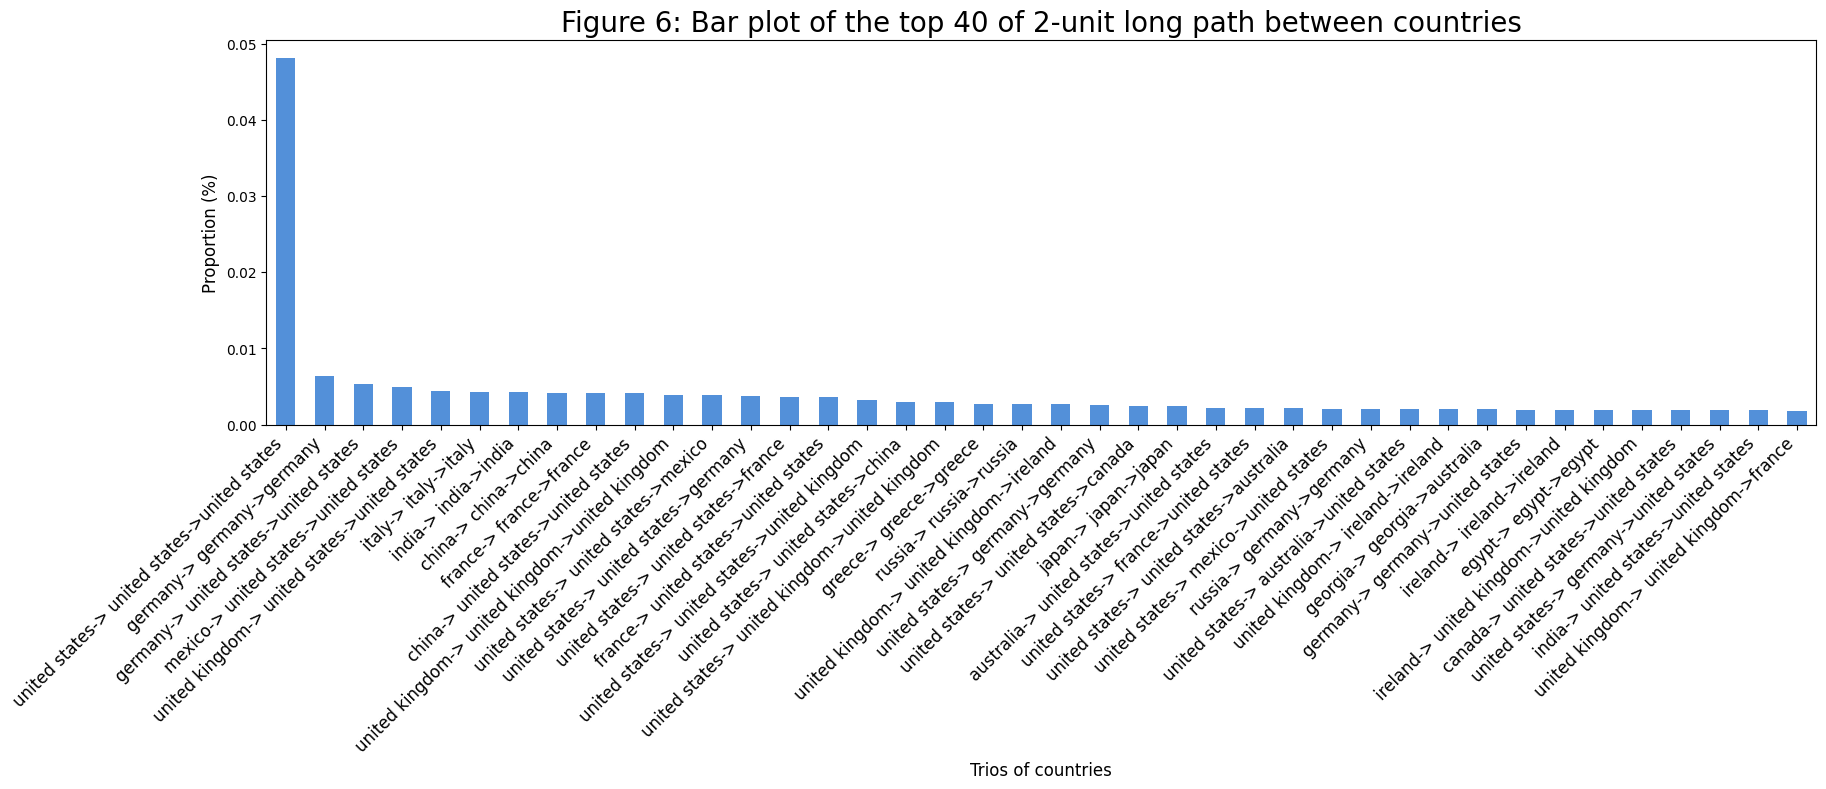

In [45]:
plt.figure(figsize=(20, 5))

top40_countries_trios.plot(kind='bar', width= 0.5, color='#5390d9')
plt.title('Figure 6: Bar plot of the top 40 of 2-unit long path between countries', fontsize=20)
plt.xlabel('Trios of countries', fontsize=12)
plt.ylabel('Proportion (%)', fontsize=12)
plt.xticks(rotation=45,ha='right',fontsize=12)

plt.show()

Similarly as the previous observation of 1-unit long path between articles, we can see that a lot of 2-unit long paths are actually within the same country. The most occurent one is United States -> United States -> United States but we also find France -> France -> France, Greece -> Greece -> Greece, etc.

And, the paths that link different countries mostly revolve around the United States. For example, Germany -> United States -> United States or Mexico -> Unites States -> Unites States are respectively the second and third most frequently used paths. This could highlight a bias of players toward this particular country.

Now, it remains to display those "highway paths" informations on a map! This will be done in Milestone P3!

## 2.3 What articles are most likely to cause a player to stop the game? What makes those articles "dead ends"? What does this have to do with the country of these articles?


Great! There are roads connecting articles that are often clicked consicutively in a same path. Another important question can be raised here: where do these roads end? This is what we will answer in this part.

In [46]:
articles = load_articles_dataframe()
categories = load_categories_dataframe()
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

In [47]:
df_articles_count = process_article_paths(finished_paths, unfinished_paths, articles)
df_articles_count.head(10)

article  total_click_count  unique_click_count  \
0               <              33468               14196   
1   United_States              12449               12010   
2          Europe               5611                5497   
3  United_Kingdom               5328                5161   
4         England               4558                4429   
5           Earth               4216                4144   
6          Africa               3590                3499   
7    World_War_II               2931                2876   
8   North_America               2594                2554   
9          Animal               2471                2373   

   unique_success_count  unique_failure_count  success_ratio_total  \
0                  8995                  5201             0.268764   
1                  8675                  3335             0.696843   
2                  4303                  1194             0.766886   
3                  3807                  1354             0.714527   
4                  3261                  1168             0.715445   
5                  3176                   968             0.753321   
6                  2738                   761             0.762674   
7                  2267                   609             0.773456   
8                  1861                   693             0.717425   
9                  1666                   707             0.674221   

   failure_ratio_total  success_ratio_unique  failure_ratio_unique  
0             0.155402              0.633629              0.366371  
1             0.267893              0.722315              0.277685  
2             0.212796              0.782791              0.217209  
3             0.254129              0.737648              0.262352  
4             0.256253              0.736284              0.263716  
5             0.229602              0.766409              0.233591  
6             0.211978              0.782509              0.217491  
7             0.207779              0.788248              0.211752  
8             0.267155              0.728661              0.271339  
9             0.286119              0.702065              0.297935

c:\Users\jerem\Documents\Informatique\AdaCourse\ada-2024-project-lesfraisestagada\src\utils\plots.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


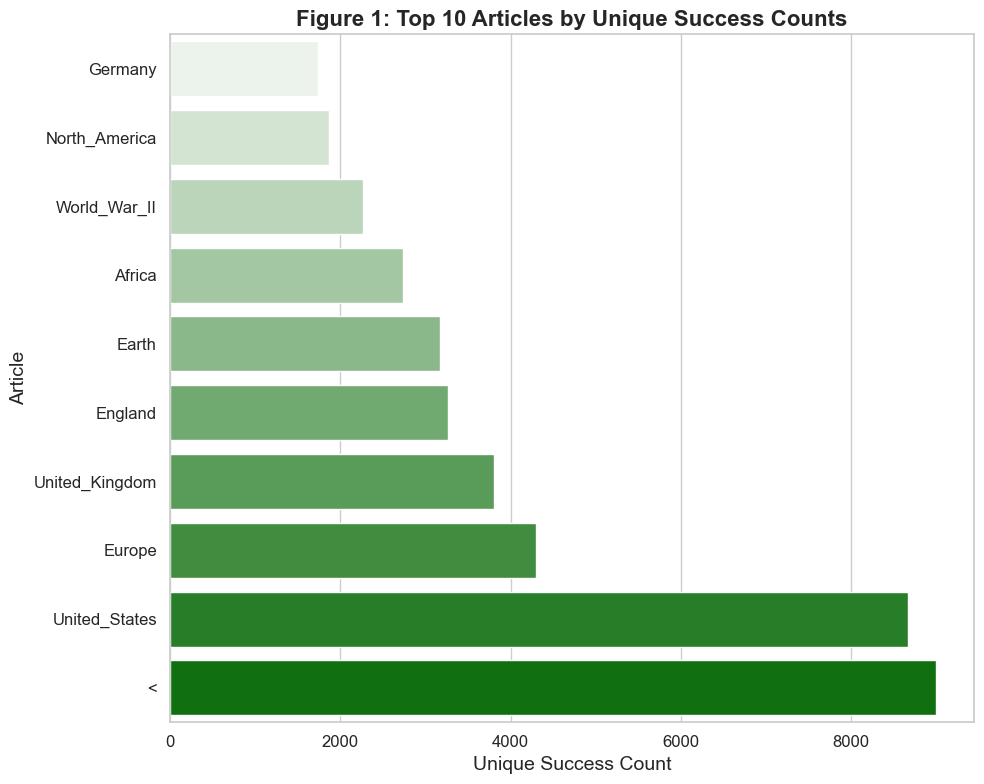

c:\Users\jerem\Documents\Informatique\AdaCourse\ada-2024-project-lesfraisestagada\src\utils\plots.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


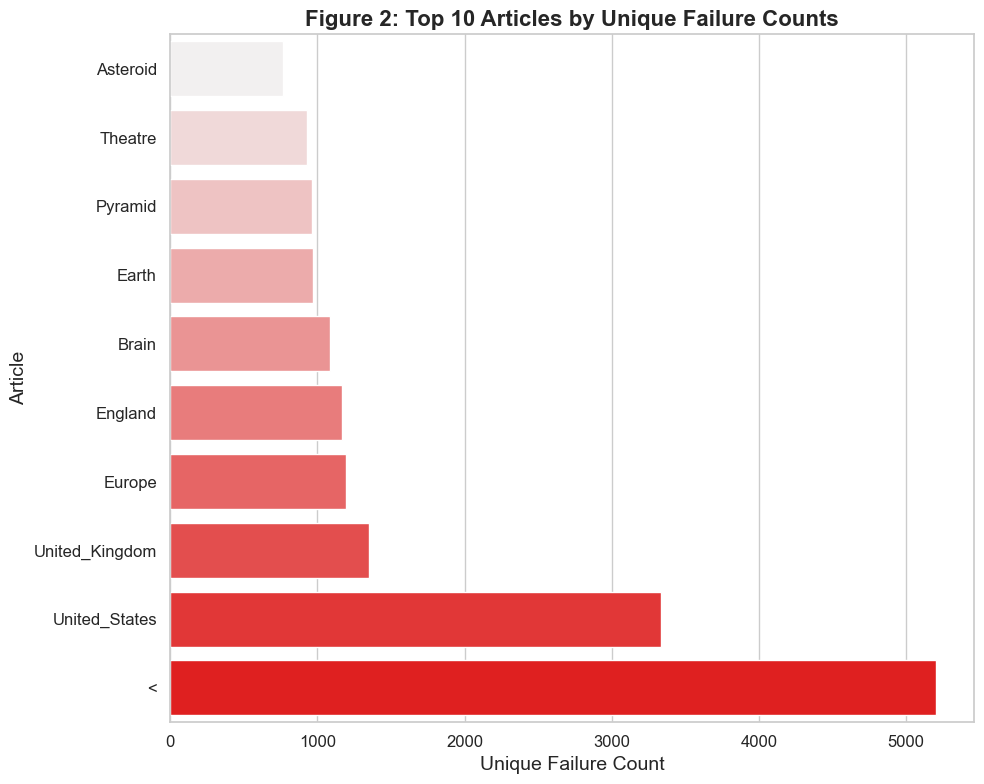

In [48]:
plot_top_k_unique_failure_success_counts(df_articles_count)

In [49]:
go_back_fail_count_u = df_articles_count.loc[df_articles_count['article'] == '<']['unique_failure_count'].values[0]
go_back_success_count_u = df_articles_count.loc[df_articles_count['article'] == '<']['unique_success_count'].values[0]
success_ratio_unique = go_back_success_count_u / (go_back_success_count_u + go_back_fail_count_u)
print(f'The go back button makes on average the player succeed {success_ratio_unique*100:.2f}% of the time')

The go back button makes on average the player succeed 63.36% of the time


This plot gives us a good insight about which articles make users fail/succeed in the Wikispeedia game :

**High success counts in historical/geographical articles** : <br/>
Articles `World_War_II`, `Africa`, and `Germany` appear in the success plot but not in the failure plot. This could indicate that these articles are part of well-connected paths (which we call highway paths) that users are more likely to complete, possibly because they relate to broader, interconnected topics.

**High success rate for the "go back" button** : <br/> 
The "<" button, which allows users to navigate back to a previous article, has a unique success count that is notably higher than its unique failure count, with a success rate of 63.36%. This means that when users go back, they end up completing their path about 63% of the time. The frequent use of the "go back" button suggests that users may often reach pages where they feel unsure of the next step or encounter content that does not meet their expectations, prompting them to backtrack.

While many users successfully navigate onward after going back, a substantial portion still abandons their path after backtracking. This frequent use of the "go back" button, especially before abandonment, implies that certain pages might be acting as dead ends or lacking clear onward navigation.

**High failure counts in specific articles** : <br/>
Certain articles like `Asteroid`, `Theatre`, and `Pyramid` appear only in the failure plot. These may represent topics that are less connected to other parts of the article network, potentially leading users to dead ends. Users reaching these pages may struggle to find relevant onward links, leading to abandonment. Unlike the historical and geographical articles that are well integrated into broader themes, these topics may lack sufficient links to related articles, making it difficult for users to continue their path without backtracking or giving up.

**Top articles with both high success and failure counts** : <br/>
Articles like `United_States`, `United_Kingdom`, and `Europe`, which appear very frequently in our analysis, have high counts in both success and failure plots. This suggests that these articles are pivotal points in the game where users frequently make navigation decisions. While these articles are often part of successful paths, they also lead to user abandons, possibly because of the wide range of potential links that may either facilitate continuation or create confusion.

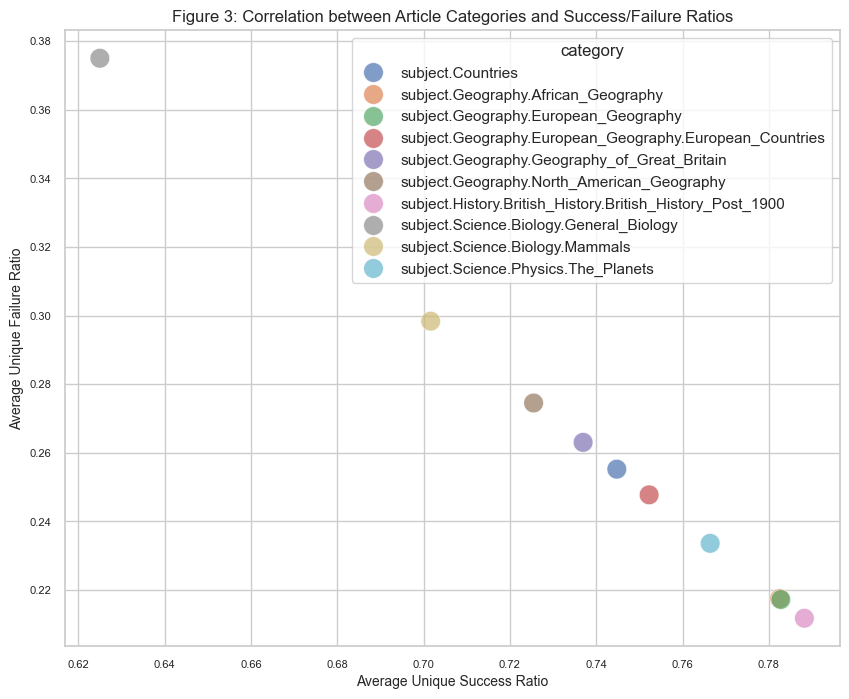

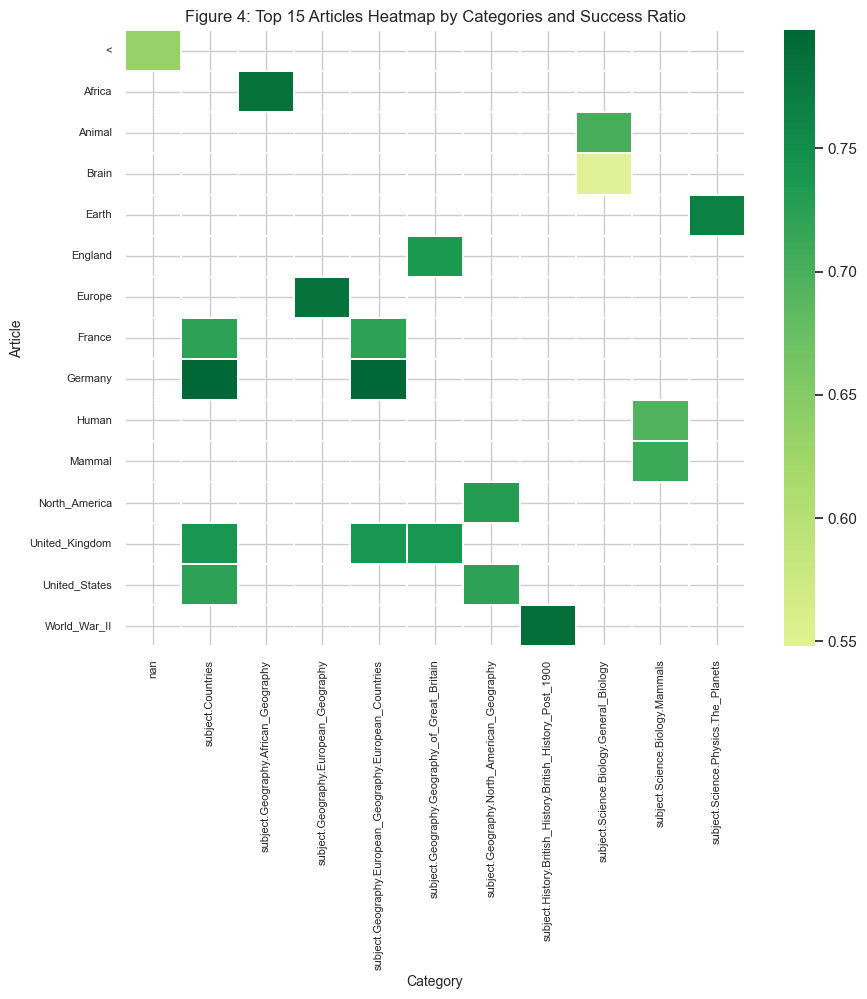

In [50]:
analyze_top_articles_by_category(df_articles_count, categories, top_n=15)

We obverse several things on the above two plots : <br/>

**Geography-related categories** : <br/>
Geography-related categories, such as `European_Geography`, `North_American_Geography`, and `African_Geography`, have high success ratios, suggesting that geographical articles are part of well-connected paths that users complete more frequently.

**Science and biology topics** : <br/>
Categories like `Mammals`, `General_Biology` show moderate success ratios, indicating that these topics might be somewhat connected but don’t facilitate completion as effectively as geography-related paths. Surprisingly, `Physics` (more particularly, The Planets), shows a very high success ratio, suggesting that users may find it easier to follow through on paths involving specific physics topics, possibly due to greater prior knowledge or more structured/linear article content.

**High success with certain historical articles** : <br/>
Historical topics, specifically `British_History_Post_1900`, have a lower failure ratio, suggesting users tend to follow through on these articles more consistently, potentially because of potentially higher knowledge on the subject or clearer onward paths.

**Heatmap distribution** : <br/> 
The heatmap emphasizes the fact that articles in the Countries and general geography categories (`European_Geography`, `Geography_of_Great_Britain`) are strongly associated with higher success ratios, reinforcing the importance of geographical hubs in successful navigation paths.
However an article like the `Brain` has a much lower success ratio, possibly due to players' lack of knowledge on this topic or the lack/complexity of outgoing links.

### What articles are most likely to cause a player to stop the game? 

In [51]:
df_country_clicks_links = pd.read_csv('data/country_clicks_links.csv', index_col=0)

In [52]:
# 1
# select top articles based on failure ratios and unique failure counts
top_dead_end_articles = df_articles_count.sort_values(by=['failure_ratio_unique', 'total_click_count'], ascending=False)
print("Top Dead-End Articles (Most Likely to Cause Players to Stop):")
top_dead_end_articles[['article', 'total_click_count', 'failure_ratio_unique', 'unique_failure_count']].head(10)

Top Dead-End Articles (Most Likely to Cause Players to Stop):


article  total_click_count  failure_ratio_unique  \
4039               Hurricane_Gloria                  4                   1.0   
4043                Hilda_of_Whitby                  4                   1.0   
4078     Malwa_%28Madhya_Pradesh%29                  4                   1.0   
4090        Eliminative_materialism                  3                   1.0   
4105  San_Diego_and_Arizona_Railway                  3                   1.0   
4111  Lynton_and_Barnstaple_Railway                  2                   1.0   
4127  Battle_of_Smolensk_%281943%29                  2                   1.0   
4129             Richard_O%27Connor                  2                   1.0   
4150               Private_Peaceful                  1                   1.0   
4156            Nadia_Com%C4%83neci                  1                   1.0   

      unique_failure_count  
4039                     4  
4043                     4  
4078                     4  
4090                     3  
4105                     3  
4111                     2  
4127                     2  
4129                     2  
4150                     1  
4156                     1

### What makes those articles "dead ends"?

In [53]:
# prepare for merge
df_country_click_links_reset = df_country_clicks_links.reset_index().rename(columns={'index': 'article'})

# merge to get the country
dead_end_countries = pd.merge(
    df_country_click_links_reset, 
    top_dead_end_articles, 
    on='article', 
    how='inner'
)

print("Top Dead-End Articles (Most Likely to Cause Players to Stop) related to link counts:")
dead_end_countries.sort_values(by=['failure_ratio_unique','total_click_count'], ascending=False)[['article', 'num_links_in', 'num_links_out', 'failure_ratio_unique']].head(10)


Top Dead-End Articles (Most Likely to Cause Players to Stop) related to link counts:


article  num_links_in  num_links_out  \
1928                Hilda_of_Whitby           2.0           16.0   
2051               Hurricane_Gloria           2.0            6.0   
2624     Malwa_%28Madhya_Pradesh%29           3.0           29.0   
1356        Eliminative_materialism           1.0           12.0   
3619  San_Diego_and_Arizona_Railway           2.0            8.0   
507   Battle_of_Smolensk_%281943%29           2.0           13.0   
2577  Lynton_and_Barnstaple_Railway           3.0           11.0   
3493             Richard_O%27Connor           1.0           35.0   
316      Architecture_of_Windows_NT           NaN            3.0   
847                             CF7           2.0            6.0   

      failure_ratio_unique  
1928                   1.0  
2051                   1.0  
2624                   1.0  
1356                   1.0  
3619                   1.0  
507                    1.0  
2577                   1.0  
3493                   1.0  
316                    1.0  
847                    1.0

These dead-end articles each have a 100% failure ratio, meaning players abandon their path every time they reach one of these pages. Many of these articles are highly specific, niche topics tied to particular historical or cultural contexts, such as `Hurricane Gloria` in the United States, `Hilda of Whitby` in early Christian England, and `Nadia Comăneci` from Romania. Despite having some incoming links, most of these pages offer limited outgoing links (such as `Architecture of Windows NT` with only 3 outgoing links), restricting the options for onward navigation. This lack of connectivity to other commonly traversed topics creates a navigational dead end, making it difficult for players to find relevant paths to continue, effectively leading to abandonment in the Wikispeedia game.

###  What does this have to do with the country of these articles?

We'd like to have unique countries in the dataframe to get a clear view of each country's overall impact as a dead-end article without redundancy.
It's important to avoid duplicate entries, which would skew metrics like total click counts and success/failure ratios. 

The following approach creates a single, summarized entry for each country, preserving meaningful metrics and avoiding arbitrary duplicate drops. It allows for a comprehensive view of each country’s overall engagement and dead-end behavior within the dataset.

In [54]:
# group by 'Top_1_name' (country) and aggregate the data
unique_dead_end_countries = (
    dead_end_countries
    .groupby('Top_1_name', as_index=False)
    .agg({
        'click_count': 'sum',             # Sum click counts to get total clicks per country
        'num_links_out': lambda x: int(round(x.sum())),          # Sum of outgoing links
        'num_links_in': lambda x: int(round(x.sum())),           # Sum of incoming links
        'unique_success_count': 'sum',    # Sum of unique success counts per country
        'unique_failure_count': 'sum',    # Sum of unique failure counts per country
        'success_ratio_total': 'mean',    # Mean of total success ratios
        'failure_ratio_total': 'mean',    # Mean of total failure ratios
        'success_ratio_unique': 'mean',   # Mean of unique success ratios
        'failure_ratio_unique': 'mean'    # Mean of unique failure ratios
    }).rename(columns={
        'num_links_out': 'sum_num_links_out',
        'num_links_in': 'sum_num_links_in',
        'success_ratio_total': 'mean_success_ratio_total',
        'failure_ratio_total': 'mean_failure_ratio_total',
        'success_ratio_unique': 'mean_success_ratio_unique',
        'failure_ratio_unique': 'mean_failure_ratio_unique'
    })
)

unique_dead_end_countries = unique_dead_end_countries.sort_values(by=['click_count'], ascending=False)

unique_dead_end_countries.head(10)

Top_1_name  click_count  sum_num_links_out  sum_num_links_in  \
202   united states        69147              16338             15369   
201  united kingdom        22753               3566              5145   
71          germany        22429               5733              6393   
87            india        19882               6238              5748   
41            china        18823               5601              5036   
65           france        16723               6040              6372   
160          russia        13688               2377              3335   
10        australia        12569               3736              2920   
94            italy        11824               2919              3906   
91          ireland         9146               3641              2836   

     unique_success_count  unique_failure_count  mean_success_ratio_total  \
202                 48485                 19117                  0.636390   
201                 15836                  6404                  0.638350   
71                  17002                  5120                  0.705586   
87                  14536                  4985                  0.674239   
41                  13682                  4796                  0.704816   
65                  11975                  4452                  0.680184   
160                 10626                  2794                  0.729619   
10                   9386                  2974                  0.651908   
94                   8344                  3261                  0.681176   
91                   6879                  2144                  0.649855   

     mean_failure_ratio_total  mean_success_ratio_unique  \
202                  0.253500                   0.642559   
201                  0.225409                   0.642702   
71                   0.239628                   0.710261   
87                   0.238783                   0.679818   
41                   0.222482                   0.709854   
65                   0.245118                   0.687588   
160                  0.234870                   0.738259   
10                   0.244766                   0.657833   
94                   0.255877                   0.687356   
91                   0.266990                   0.655411   

     mean_failure_ratio_unique  
202                   0.256352  
201                   0.227161  
71                    0.241254  
87                    0.240816  
41                    0.224356  
65                    0.247735  
160                   0.237645  
10                    0.247230  
94                    0.258098  
91                    0.269589

In [55]:
plot_top_dead_end_countries(unique_dead_end_countries, i=5)

This horizontal bar plot shows top 10 country-related dead-end articles' countries ranked by their mean failure ratio.
It highlights the likelihood of players abandoning paths when they reach these country articles. Each country displayed has a relatively high mean failure ratio, indicating that players often encounter challenges in continuing their path. Interestingly and this was to be expected, some small or less well-known territories, such as Niue, Cocos (Keeling) Islands, and Pitcairn Islands, have high failure ratios despite having varying numbers of outgoing links. This suggests that even with moderate connectivity (links out), these articles fail to provide sufficient onward navigation options relevant to player goals.

The color gradient, which represents the average number of outgoing links, shows that having more outgoing links (e.g., San Marino with a high link count) **does not necessarily reduce failure rates in this case**, indicating that the relevance or connectivity of these links on more niche articles may be limited within the game's structure.

### What if we take into account the click counts?

These countries have a very low click count, what if we take into account the number of clicks ? 

In [56]:
plot_top_dead_end_countries(unique_dead_end_countries, use_click_count=True, i=6)

Uh oh, this plot might be biased. Not only has the `United States` received an overwhelmingly high number of clicks, but it also has significantly more outgoing links sum (16338) than other countries, which likely increases its visibility and accessibility. This high connectivity makes it easier for users to encounter the United States in their paths, thereby inflating its click count relative to less-linked countries. Additionally, cultural or linguistic familiarity with certain countries, like the US or the UK might lead users to click on these articles more frequently, introducing a familiarity bias into the data.

To prevent this, we have to scale the number of clicks per country by the sum of outgoing links of those countries in the Wikipedia data. 

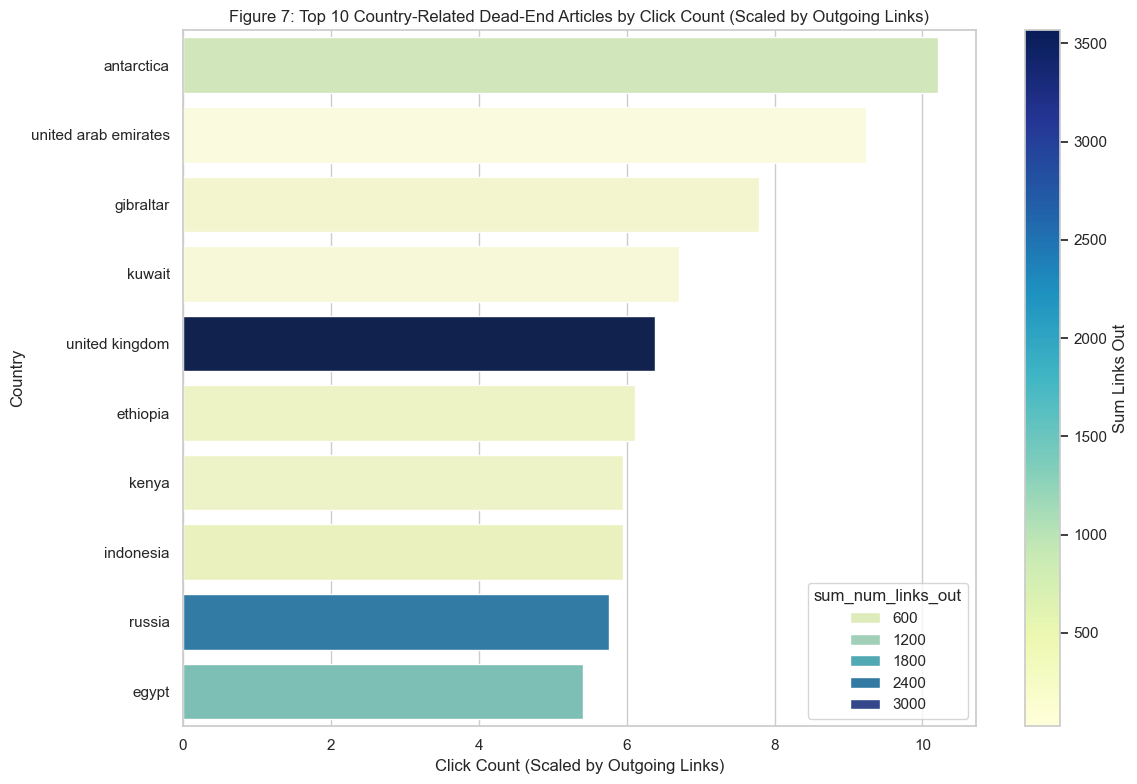

In [57]:
# Scale the click count by the mean number of outgoing links
unique_dead_end_countries["scaled_click_count"] = unique_dead_end_countries["click_count"] / unique_dead_end_countries["sum_num_links_out"]

# Plot using the updated DataFrame with scaled click count
plot_top_dead_end_countries(unique_dead_end_countries, use_click_count=True, use_scaled=True, i=7)


This is quite revealing!

- The initial plot shows a tendency for highly connected countries like the United States and United Kingdom to appear frequently as dead ends, largely due to their high number of outgoing links, which naturally draw in more clicks and interactions.
- After scaling, less connected countries (e.g., Antarctica, United Arab Emirates) come into focus, indicating that players often end up at these pages not solely because of link density but perhaps due to interest or paths that commonly lead to these locations.

Thus, scaling sheds light on genuine player navigation patterns, reducing the visibility of well-connected hubs and highlighting countries that act as dead ends even with fewer outgoing links, suggesting significant player engagement or specific interest.

### Let's analyse the last article's country of unfinished paths(how many times does it appear? is it a dead end ?)

c:\Users\jerem\Documents\Informatique\AdaCourse\ada-2024-project-lesfraisestagada\src\utils\plots.py:343: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


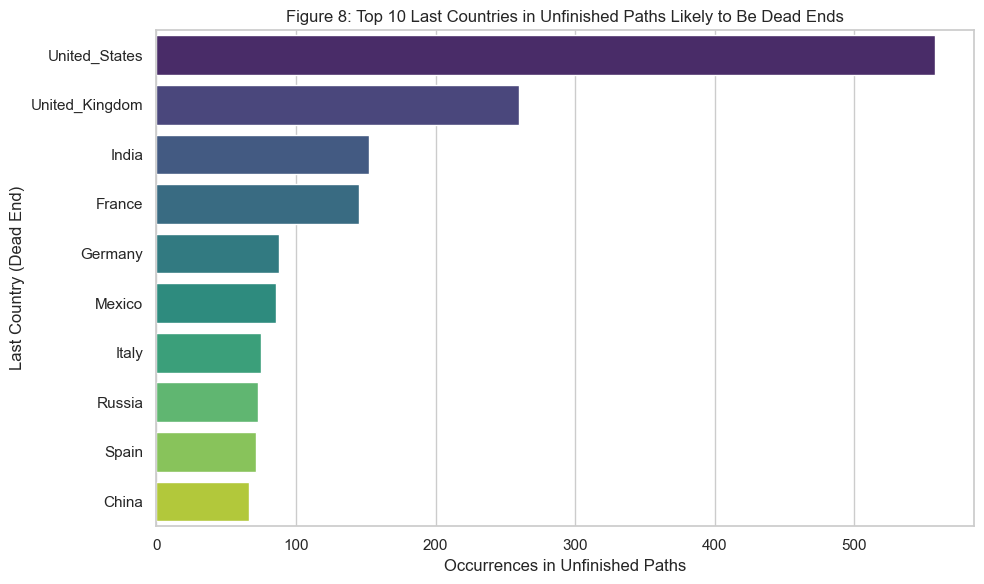

In [58]:
last_dead_end_countries = analyze_last_articles_in_unfinished_paths(unfinished_paths, unique_dead_end_countries)
plot_top_last_dead_end_countries(last_dead_end_countries, i=8)

### scaled by the number of links out

c:\Users\jerem\Documents\Informatique\AdaCourse\ada-2024-project-lesfraisestagada\src\utils\plots.py:343: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


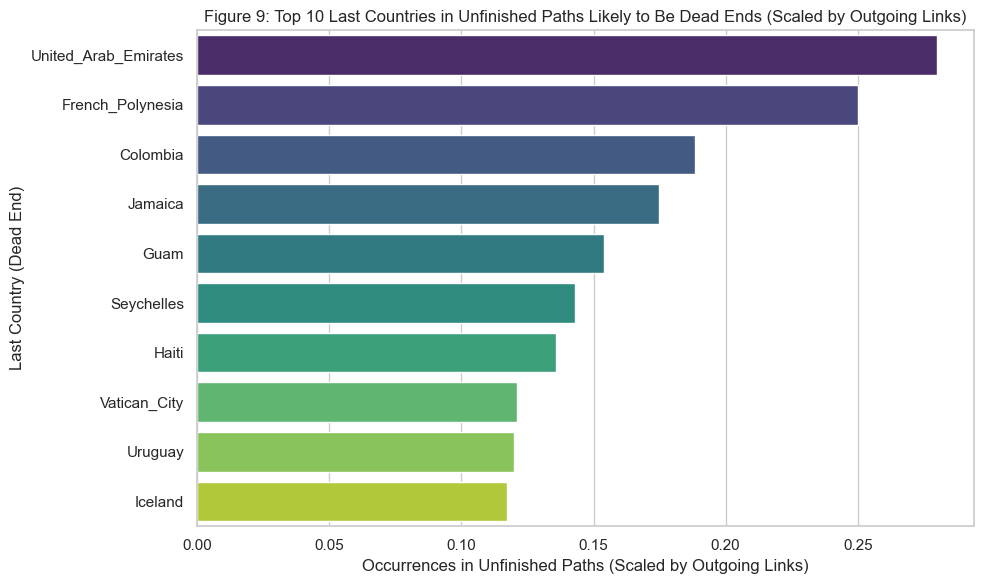

In [59]:
# calculate scaled values for plotting
last_dead_end_countries['scaled_count'] = last_dead_end_countries['count'] / last_dead_end_countries['sum_num_links_out']
plot_top_last_dead_end_countries(last_dead_end_countries, use_scaled=True, i=9)

This analysis again provides interesting insights!

- In the first plot, we see that highly connected countries like the United States and United Kingdom frequently appear as the last countries in unfinished paths, likely due to their high click count and connectivity. Their numerous outgoing links make them common endpoints when players get stuck in navigation.
- The scaled plot, however, reveals a different trend: countries with fewer outgoing links, such as the United Arab Emirates and French Polynesia, stand out as prominent dead ends. This indicates that users often land on these pages not merely due to connectivity but due to specific navigational patterns or interests that naturally lead them to these locations.

Therefore scaling shows countries that serve as genuine dead ends, even with limited outgoing links, reflecting meaningful user engagement and specific pathways within the game and failure when encountering these articles countries.

### Pushing it further : 
#### Get the count of all articles that come before the "<" and link it with the failure ratio

c:\Users\jerem\Documents\Informatique\AdaCourse\ada-2024-project-lesfraisestagada\src\utils\plots.py:383: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


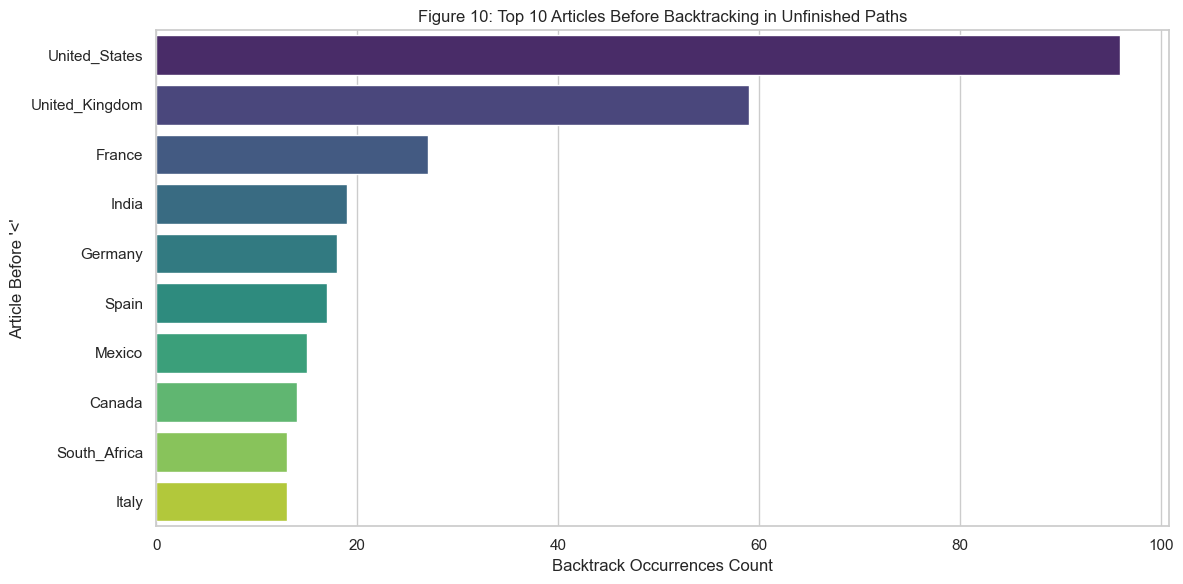

In [60]:
articles_before_go_back_sorted = get_articles_before_go_back(unfinished_paths, unique_dead_end_countries)
plot_articles_before_go_back(articles_before_go_back_sorted, i=10)

c:\Users\jerem\Documents\Informatique\AdaCourse\ada-2024-project-lesfraisestagada\src\utils\plots.py:383: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


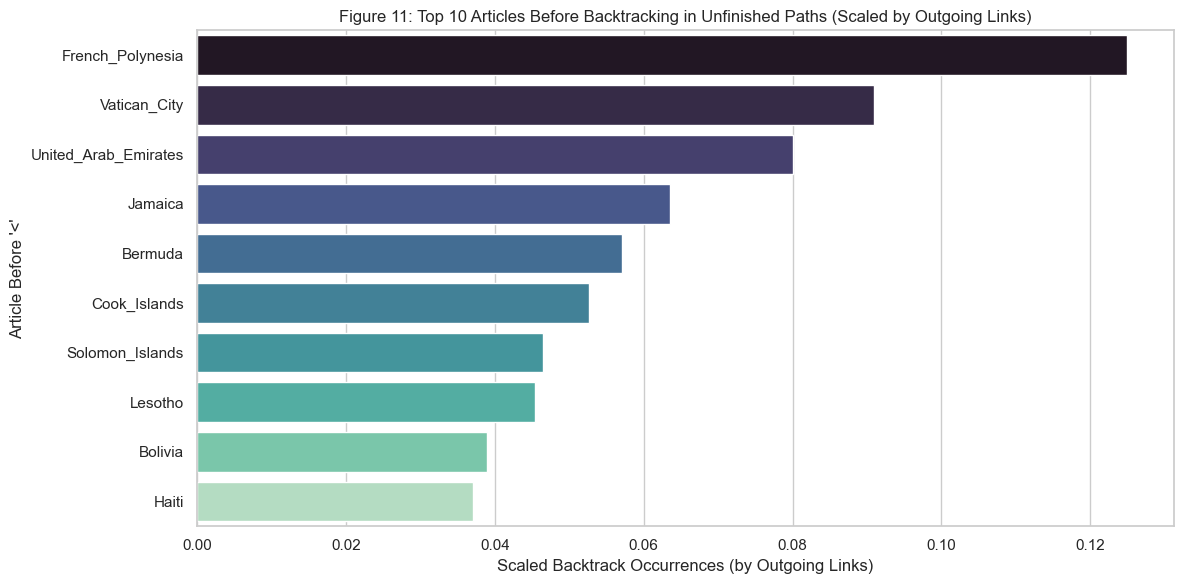

In [61]:
plot_articles_before_go_back(articles_before_go_back_sorted, use_scaled=True, i=11)

**Raw Occurrences Before Backtracking**:
- The first graph shows the most frequently encountered articles before players choose to backtrack. Highly connected countries like the United States and United Kingdom dominate this list. These articles likely serve as broad hubs, where players reach a point of indecision or difficulty, leading to backtracking.

**Scaled Occurrences (by Outgoing Links)**:
- After scaling by outgoing links, less prominent or isolated locations like French Polynesia, Vatican City, and Jamaica emerge as significant. These articles may act as dead ends due to limited onward navigational options, even if they don’t receive high raw click counts. This highlights places where players may feel stuck despite the initial attraction, indicating a need for more links or clearer paths to navigate away.

Overall, scaling reveals player patterns and difficulties in less connected areas, while the raw data underscores challenges in more popular, well-connected hubs.

# 3. How can we explain the players' biases?

Now that we have finished a naive analysis of the player's biases in the Wikispeedia game, let's further investigate the intrinsic biases of the Wikipedia graph. 


## 3.1 What is the distribution of countries among start / target articles for the Wikispeedia games? If it is not balanced, could this be an explanation?

### Analysis of the countries relations between the start and the end of finished paths.

In [62]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].fillna("[]")
country_clicks["num_links_in"] = country_clicks["num_links_in"].fillna(0)
country_clicks["num_links_out"] = country_clicks["num_links_out"].fillna(0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].apply(literal_eval)

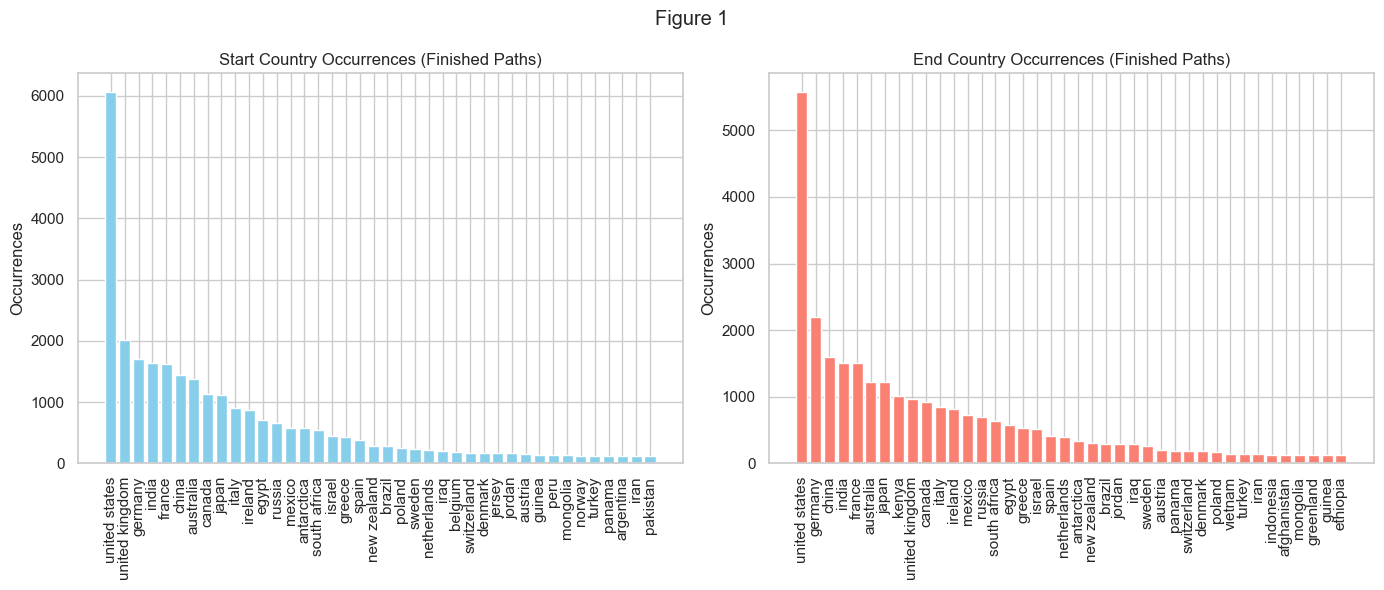

In [63]:
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

finished_paths["path"] = finished_paths["path"].str.split(";")
unfinished_paths["path"] = unfinished_paths["path"].str.split(";")

paths_to_country(finished_paths, country_clicks, fig_num="1", finished=True)
    

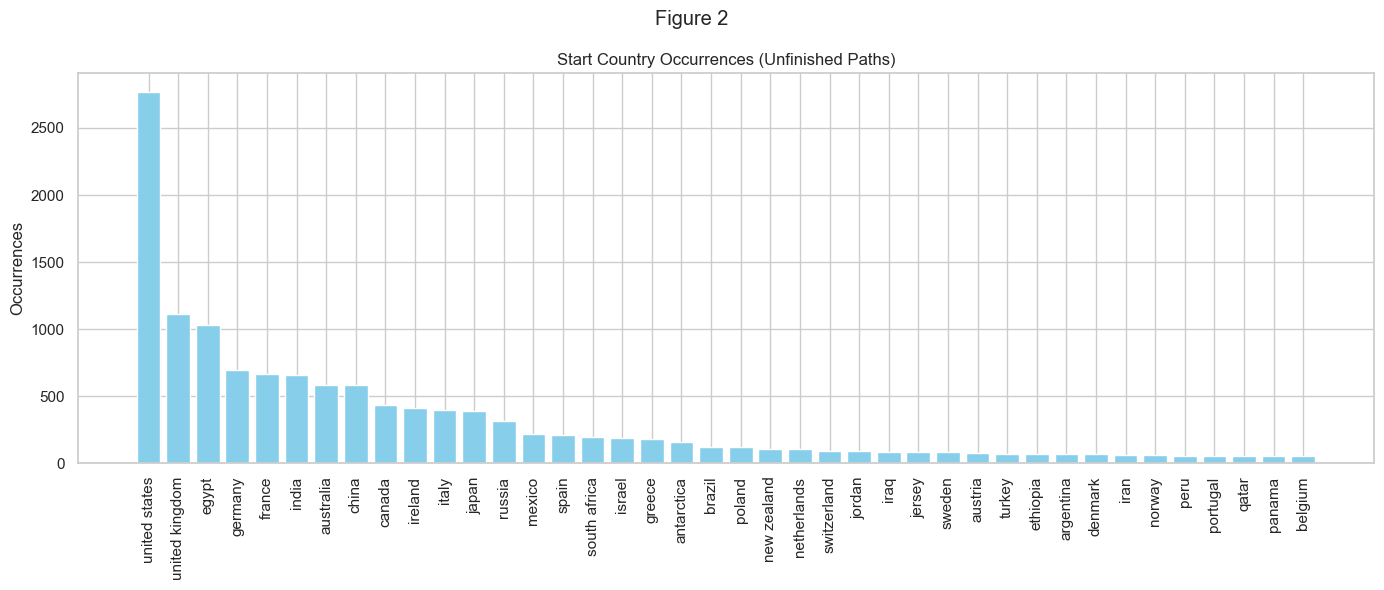

In [64]:
paths_to_country(unfinished_paths, country_clicks, fig_num="2", finished=False)


We see that for finished or unfinished path the trend is that articles related to the United States are mostly "selected" as start articles for players. This implies that it counts as a click in the clicks_count statistics and implicitely creates a bias towards some countires even before the game has started. This can be explained by the fact that  start and end articles for a game are randomly selected which implies that that they will overrepresent the countries having more articles and underrepresent articles related to countries with few articles.

An ideal game for our experimental setup would be to have the same number of chances to have an article from the USA's as start than an article from every other country.

## 3.2 Can we explain the variance in player's click counts with the number of links leading in and out of article?

The first approach is based on the fact that we observed that a lot of articles are classified into 2 predominant countries categories. We thus thought that the country category could have an impact on the number of clicks an article is getting. 
We used an ordinary least squares solver in order to describe this data and tried to predict : 
```click_count ~ num_links_in + num_links_out + C(Top_1_name)```
The number of incoming/outgoing links can also be seen as a useful feature in order to predict the number of clicks an article recieves so this is why there are also included. 
In this case neither num_links_in, num_links_out or click_count were normalized since it is more intuitive to have coefficients in terms of clicks than in term of probabilities. In case the outputs need to be normalized, uncomment the following lines

In [65]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["log_click_count"] = np.log(country_clicks["click_count"] + 1)
country_clicks["log_num_links_in"] = np.log(country_clicks["num_links_in"] + 1)
country_clicks["log_num_links_out"] = np.log(country_clicks["num_links_out"] + 1)
# country_clicks["click_count"] = country_clicks["click_count"] / country_clicks["click_count"].sum()
# country_clicks["num_links_in"] = (country_clicks["num_links_in"] - country_clicks["num_links_in"].mean()) / country_clicks["num_links_in"].std()
# country_clicks["num_links_out"] = (country_clicks["num_links_out"] - country_clicks["num_links_out"].mean()) / country_clicks["num_links_out"].std()

In [66]:
mod = smf.ols(formula='click_count ~ num_links_in + num_links_out + C(Top_1_name)', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     29.99
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:20:57   Log-Likelihood:                -22346.
No. Observations:                3330   AIC:                         4.512e+04
Df Residuals:                    3116   BIC:                         4.643e+04
Df Model:                         213                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

By analysing the coefficients we see that all p-values of country categories are larger than the alpha-level of 5% (except for antartica for which p-value = 0.003 < 0.05), so we can reject the hypothesis that the countries have a meaningful impact on the number of clicks an article recieves at a significant level. ```Antarctica``` was found to be a significant variable to estimate the number of clicks that an article might get. The coefficient of this variable is 248, meaning that according to the regression, if an article is related to the country of Antarctica, it has 248 times for changes to be clicks. This is very suprising! And might arise from the fact that articles such are 'Earth' (which has a huge amount of clicks: 4216), are associated to Antarctica. Those articles might drive the association between the click count and the variable Antarctica!

Note: The [2] warning tells us that we have a problem of multicollinearity which means that multiple of our independent variables are likely correlated. This can induce misleading conclusions. Below we go to a simpler model resolving this problem. We also have a very stron AIC value wich is due to the fact that we have many parameters in our model (all countries + num_links_in + num_links_out)

Given the results another variable we can't reject at a significant level of 5% is the ```num_links_in``` (p-value = 0 because so small that it is approximated by 0). We will thus further analyse this with a simpler model :  
```click_count ~ num_links_in```

In [67]:
mod = smf.ols(formula='click_count ~ num_links_in', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     7054.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:20:57   Log-Likelihood:                -27772.
No. Observations:                4135   AIC:                         5.555e+04
Df Residuals:                    4133   BIC:                         5.556e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.5745      3.399     -2.523   

Doing the regression of the log of the click counts (reflex to model the log instead of the raw data since the click count ressembles a power law) using the log of the number of links into the article significantly improves the model! Indeed, the AIC is hugely lowered and the R-squared is stable!

```log_click_count ~ log_num_links_in```

In [68]:
mod = smf.ols(formula='log_click_count ~ log_num_links_in', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        log_click_count   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     6703.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:20:57   Log-Likelihood:                -4772.9
No. Observations:                4135   AIC:                             9550.
Df Residuals:                    4133   BIC:                             9562.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7804      0.027  

In both above cases it can be seen that the both the intercept and the num_links_in coefficients are significant at the 5%-level and are thus significant in order to predict the number of clicks an articles recieves. This means that the number of incoming links is related to the number of clicks an article has and moreover each incoming link increases the chance of an article to be clicked by nearly 4, for the non-log-transformed model, and by 0.78 for the log-transformed model. 

For completeness we will look at another simple model :  
```click_count ~ log_num_links_out```

In [69]:
mod = smf.ols(formula='click_count ~ log_num_links_out', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     408.4
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           4.64e-87
Time:                        16:20:57   Log-Likelihood:                -32675.
No. Observations:                4586   AIC:                         6.535e+04
Df Residuals:                    4584   BIC:                         6.537e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -254.6998     17.93

In this case it can be seen that the both the intercept and the log_num_links_out coefficients are significant at the 5%-level and are thus significant in order to predict the log number of clicks an articles recieves. This means that the log number of links going out of an article is related to the log number of clicks an article has and moreover each incoming link increases the chance of an article to be clicked by 5.7. Still, the R-squared value is low (i.e. 0.082), showing that only 8.2% of the variance in click counts can be explained by the number of clicks going out of the articles. There has to be something more to catch up to this unexplained variance (likely the number of links in as demontrated above). 

We will provide a last analysis trying to see if the number of outgoing links are significant to the number of clicks an article recieves (everything in log-scale of course!). 
The formula used for this is : ```log_click_count ~ log_num_links_in * log_num_links_out``` so that the cross term is also present.

In [70]:
mod = smf.ols(formula='log_click_count ~ log_num_links_in * log_num_links_out', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        log_click_count   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2245.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:20:57   Log-Likelihood:                -4743.3
No. Observations:                4129   AIC:                             9495.
Df Residuals:                    4125   BIC:                             9520.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

The results suggest that the number of incoming and outgoing links, as well as the interaction between them, significantly contribute to predicting the click count of an article. Specifically:

- Number of incoming links (log_num_links_in): Each additional incoming link is associated with an increase of approximately 0.65 clicks on average (coefficient: 0.65). This positive coefficient implies that the more links pointing to an article, the higher its visibility and the potential clicks it receives. This effect is statistically significant with a very low p-value (<0.001).

- Number of outgoing links (log_num_links_out): Each outgoing link reduces the click count by about 0.14 clicks (coefficient: -0.14), suggesting that articles with more outgoing links may divert readers attention away, leading to fewer clicks. This negative effect is also statistically significant (p < 0.001).

- Interaction between incoming and outgoing links (log_num_links_in:log_num_links_out): The positive interaction term (coefficient: 0.042) indicates that articles with both high incoming and outgoing links experience a slightly amplified effect on click count. This means that for articles with many incoming links, the negative effect of outgoing links is somewhat mitigated. This subtle effect is also significant (p < 0.001).

The overall Model Fit
R-squared: The R-squared value of 0.62 suggests that approximately 62.0% of the variance in click counts is explained by this model, which indicates a good fit.
F-statistic: The high F-statistic (~2245.) with a p-value near zero confirms that the model is statistically significant overall.

It could be that certain articles are clicked more often simply because they contain more links and this information might be intuitively known by the players of the Wikispeedia game which could explain way they tend to click on those "link hub" articles. It could also be that the articles that are most clicked are those that are most cited in other articles. This would mean that players have higher chances to encounter those articles which could explain the higher click count. 

To investigate those 2 hypotheses, we will look at the correlations between the number of clicks and the number of links in and out of articles. 

In [71]:
country_clicks[['num_links_in', 'num_links_out','click_count', 'log_click_count', 'log_num_links_in']].corr(method="spearman")

num_links_in  num_links_out  click_count  log_click_count  \
num_links_in          1.000000       0.587972     0.781284         0.781284   
num_links_out         0.587972       1.000000     0.488208         0.488208   
click_count           0.781284       0.488208     1.000000         1.000000   
log_click_count       0.781284       0.488208     1.000000         1.000000   
log_num_links_in      1.000000       0.587972     0.781284         0.781284   

                  log_num_links_in  
num_links_in              1.000000  
num_links_out             0.587972  
click_count               0.781284  
log_click_count           0.781284  
log_num_links_in          1.000000

Indeed, we see that there is a strong relationship between the number of links into the article and the click count of that article (spearman correlation coefficient of 0.78) showing again that the number of links leading to an article is a good predictor for the number of clicks that this article will receive. 

To have a visual representation of the relationships between the clicks and the number of links in and out for each article we plot below three scatter plots. On top of each plot we display the regression line found by the above OLS regressions.

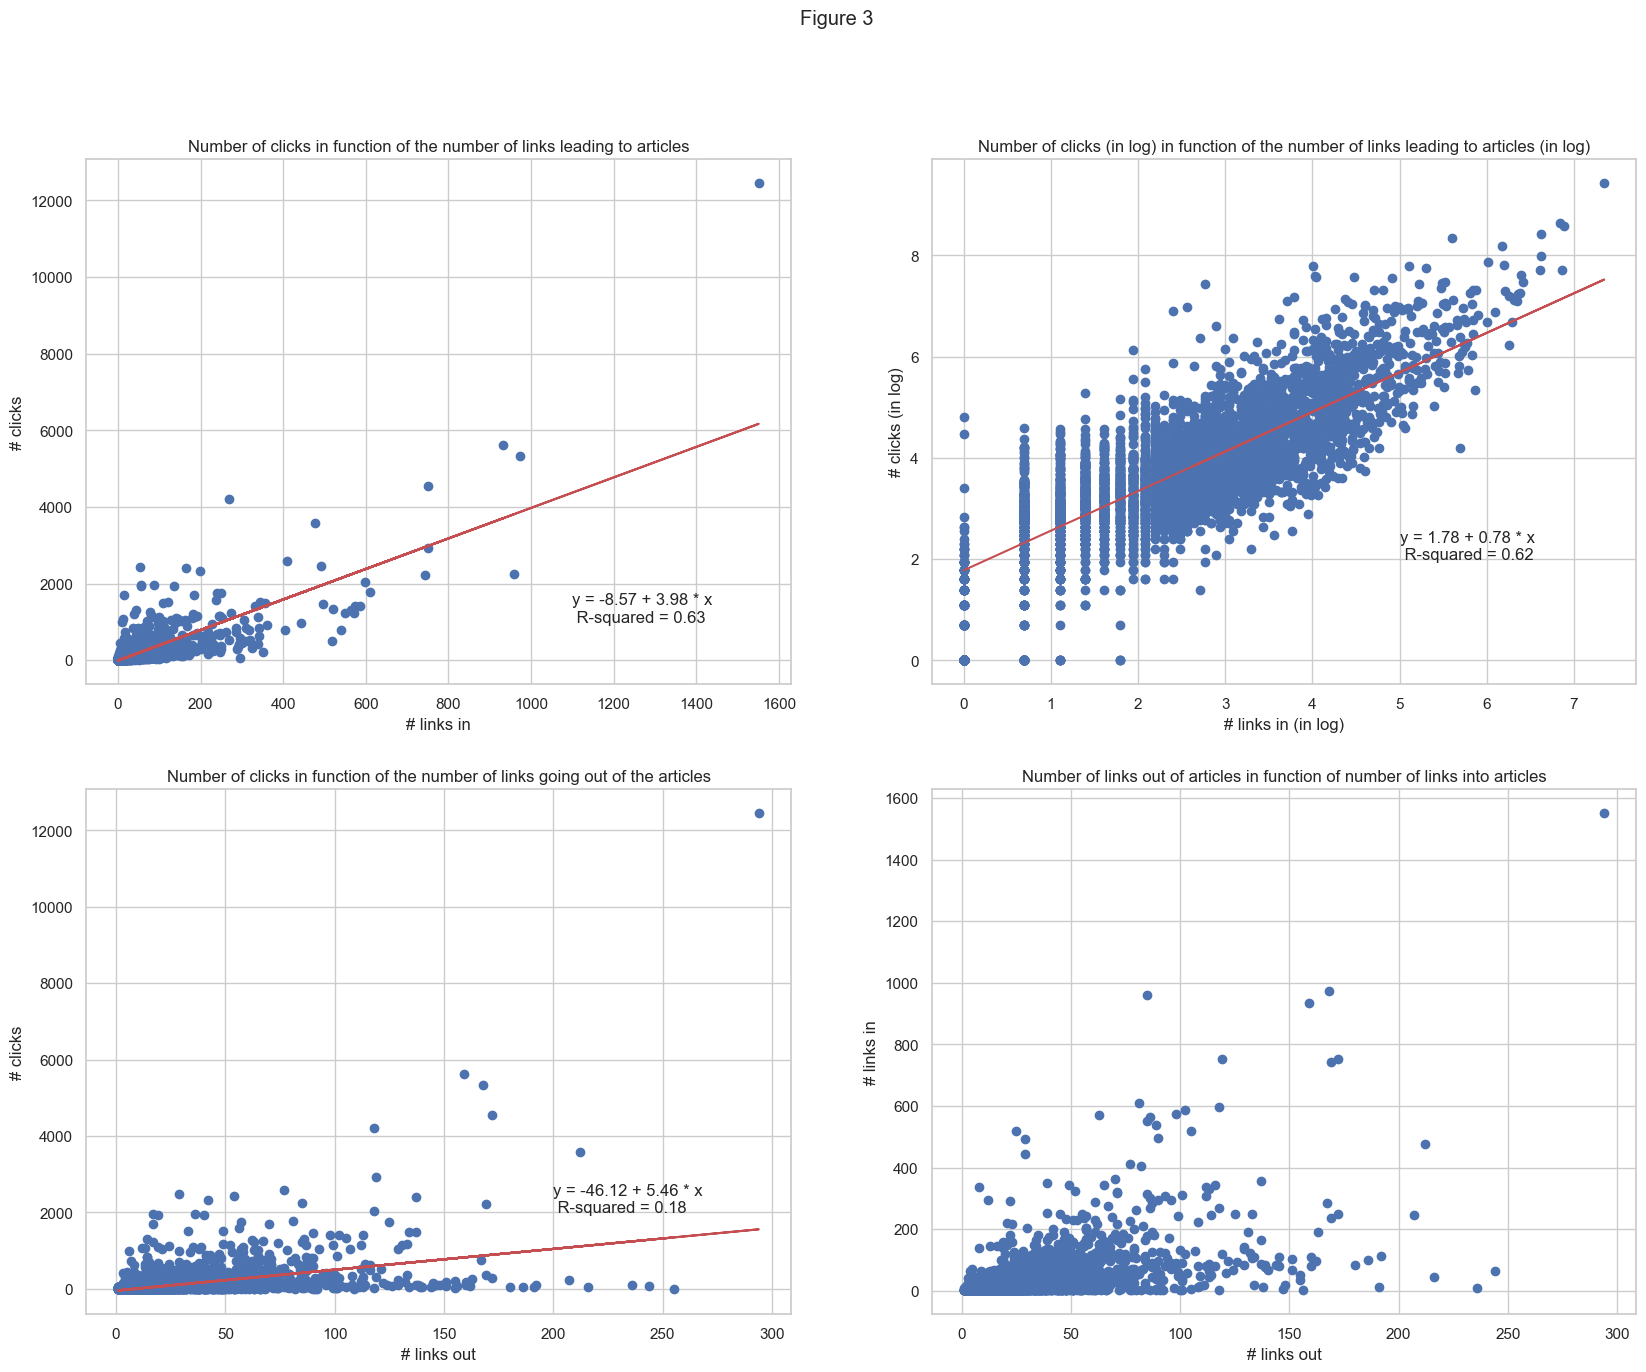

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

plot_regression_clicks_links(x=country_clicks['num_links_in'], y=country_clicks['click_count'], ax=axes[0][0], 
                             position=[1100, 1000], x_label="# links in", y_label="# clicks", 
                             title="Number of clicks in function of the number of links leading to articles", 
                             intercept=-8.5745 , slope=3.9825, r=0.631)

plot_regression_clicks_links(x=country_clicks['log_num_links_in'].fillna(0), y=country_clicks['log_click_count'], ax=axes[0][1], 
                             position=[5, 2], x_label="# links in (in log)", y_label="# clicks (in log)", 
                             title="Number of clicks (in log) in function of the number of links leading to articles (in log)", 
                             intercept=1.7804 , slope=0.7818, r=  0.619)

plot_regression_clicks_links(x=country_clicks['num_links_out'], y=country_clicks['click_count'], ax=axes[1][0], 
                             position=[200, 2000],x_label="# links out", y_label="# clicks", 
                             title="Number of clicks in function of the number of links going out of the articles", 
                             intercept=-46.1202 , slope=5.4554, r= 0.177)

axes[1][1].scatter(x=country_clicks['num_links_out'], y=country_clicks['num_links_in'])
axes[1][1].set_xlabel("# links out")
axes[1][1].set_ylabel("# links in")
axes[1][1].set_title("Number of links out of articles in function of number of links into articles")

plt.suptitle("Figure 3")

plt.show()

## 3.3 How does the players' clicking behavior compare itself to PageRank? Are players significantly more biased than a random walk on the graph?

In the previous part, we saw that the click counts of the players can be partly explained by the structure of the graph. But how much does the graph influence the players ? If we could completely remove the bias from the graph, would we still see a bias in the way players choose their paths ? To answer this question, we will compare the players' clicking behavior with a random walk on the graph, and see whether the players are "more biased" than a random walker.

### Running PageRank
First, let us the PageRank algorithm on the Wikipedia graph. We use a helper function for this that takes as input the edges from the Wikipedia graph, that is the links dataframe.

In [73]:
links_df = load_links_dataframe()
df_pagerank = pagerank(links_df)
df_pagerank

article_name      rank
0                           United_States  0.009566
1                                  France  0.006423
2                                  Europe  0.006340
3                          United_Kingdom  0.006235
4                        English_language  0.004865
...                                   ...       ...
4587                          Grange_Hill  0.000033
4588  Grand_Central_Station_%28Chicago%29  0.000033
4589                        Gowanus_Canal  0.000033
4590                      Gordon_Griffith  0.000033
4591                           Zara_Yaqob  0.000033

[4592 rows x 2 columns]

### Computing players rank based on their click counts
Next, we will compute a rank similar to that of PageRank, but based on the click counts of the players. For each article $a$, we define its rank as:
$$r_a = \frac{c_a}{\sum_{a' \in A}{c_{a'}}}$$
where
* $c_a$ is the click count of the article $a$ (the number of times it appears in the recorded player paths)
* $A$ is the set of all articles in the Wikipedia graph
With this definition we have that $ 0 \le r_a \le 1 \hspace{2mm} \forall a$ and $\sum_{a \in A}{r_a} = 1$ which are the properties necessary to compare our ranks with PageRank.

A few notes:
* Here we want our rank $r_a$ to describe as closely as possible the decisions of the players, so that we can compare it to PageRank which will be considered the baseline (a random walker makes no decisions at all). However we need to be careful: as shown in 3.1, the distribution of start / target articles in the paths is heavily biased towards USA and UK, due to the biased distribution of articles in the graph. Thus, when computing the click counts for articles, we need to not take into account those articles, since they do not truly represent the players decisions (the start / target articles are not chosen by the players!). So we remove the start and target articles (first and last articles for finished paths, and first articles for unfinished paths) before computing click counts.
* There is a special article in the graph called `Wikipedia_Text_of_the_GNU_Free_Documentation_License`. During the analysis, it was found that it has a relatively high click_count (~150), although in the graph it has in-degree and out-degree of 0 (thus a PageRank of 0). Upon closer observation, we saw that it was actually linked in all Wikipedia articles, at the bottom, as part of the license. Thus, during games, players could reach it from any article, and this was recorded in the players paths. However, in the graph data given to us, this article is considered to have in-degree 0 (which makes sense, otherwise we would have an article with an enormous in-degree, given that it is linked in all Wikipedia articles). Thus for better analysis, we decided to discard that article as its rank $r_a$ was much higher than the PageRank of 0.

In [74]:

articles = load_articles_dataframe()
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()
paths_merged = pd.concat([finished_paths["path"].apply(lambda row: row.split(';')[1:-1]), unfinished_paths["path"].apply(lambda row: row.split(';')[1:])])
# Remove start / target articles (see notes above)
df_clicks = click_count_in_paths(articles, paths_merged)
df_clicks = df_clicks[df_clicks.index != 'Wikipedia_Text_of_the_GNU_Free_Documentation_License'] # Remove GNU license article (see notes above)
df_player_frequencies = df_clicks.copy()
df_player_frequencies.click_count = df_player_frequencies.click_count / df_player_frequencies.click_count.sum()
df_player_frequencies.rename(columns={'click_count': 'rank'}, inplace=True)
df_player_frequencies.index.name = 'article_name'
df_player_frequencies.reset_index(inplace=True)
df_player_frequencies.sort_values(by='rank', ascending=False, inplace=True, ignore_index=True)
df_player_frequencies

there are 348573 clicks in the whole whikispeedia dataset (both finished and unfinished paths)


article_name      rank
0                        United_States  0.039272
1                               Europe  0.017629
2                       United_Kingdom  0.016756
3                              England  0.013664
4                                Earth  0.013124
...                                ...       ...
4598                         Canaletto  0.000000
4599                          Nathu_La  0.000000
4600                    Cape_Porcupine  0.000000
4601                      Nanomedicine  0.000000
4602  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  0.000000

[4603 rows x 2 columns]

Let us first plot a raw comparison of the top 40 PageRank articles and the associated players rank

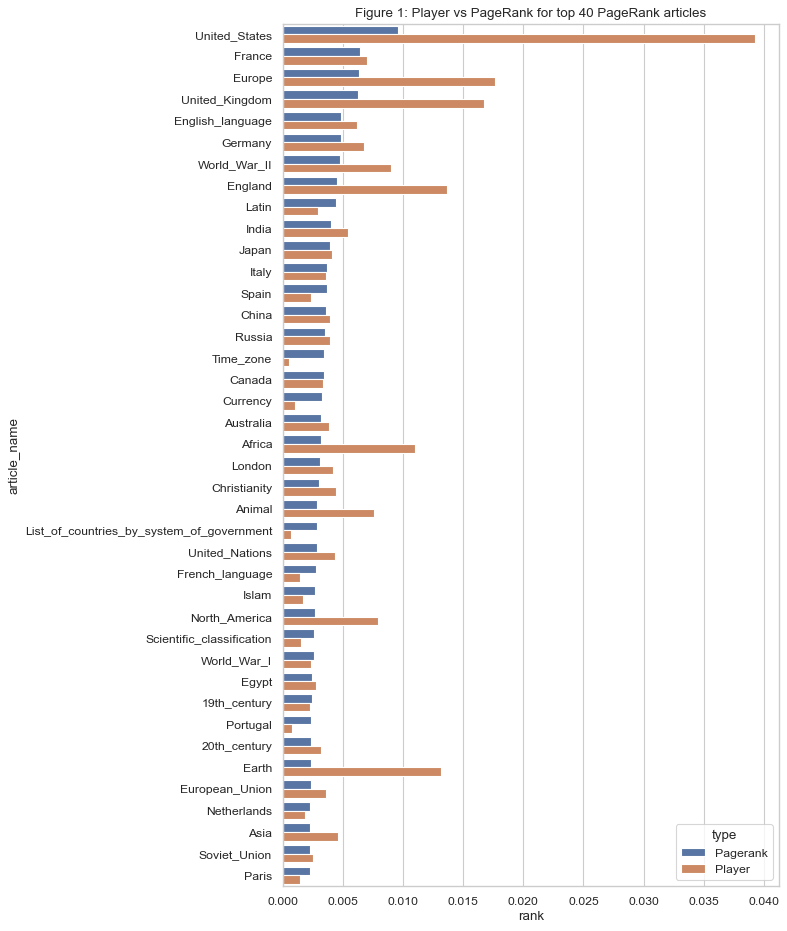

In [75]:
top_player_vs_pagerank_article_frequencies(df_player_frequencies, df_pagerank)

We see that for a lot of articles from Western cultures like `United_States`, `Europe` or `England`, the players rank is higher! However, articles like `Africa` also have a higher player rank. Given that players usually try to reach hubs in their paths to the target article, it is to be expected that general articles like `Africa` still get a higher rank: they are considered by players like "general knowledge hubs" and are often targeted by players. This is an issue: some articles will have a very high rank just because they are considered hubs by players. To make an analysis that is not too sensitive on such articles, we will go coarser grain: we will aggregate articles by country, and compute a rank for each country. the rank for a country $c$ is simply:
$$r_c = \sum_{a \in A_c} r_a$$
where
* $A_c$ is the set of all articles linked to the country $c$

To do that, we associate each article with its country.

In [76]:
article_to_countries = pd.read_csv('data/country_occurences.csv', index_col=0)[['Top_1_name']]
article_to_countries.rename(columns={'Top_1_name': 'country_name'}, inplace=True)
article_to_countries.index.name = 'article_name'
article_to_countries.reset_index(inplace=True)

df_player_frequencies = pd.merge(df_player_frequencies, article_to_countries, on='article_name')
df_pagerank = pd.merge(df_pagerank, article_to_countries, on='article_name')

Now that each article is associated to a country, we can draw the same graph, but comparing country aggregates instead of individual articles.

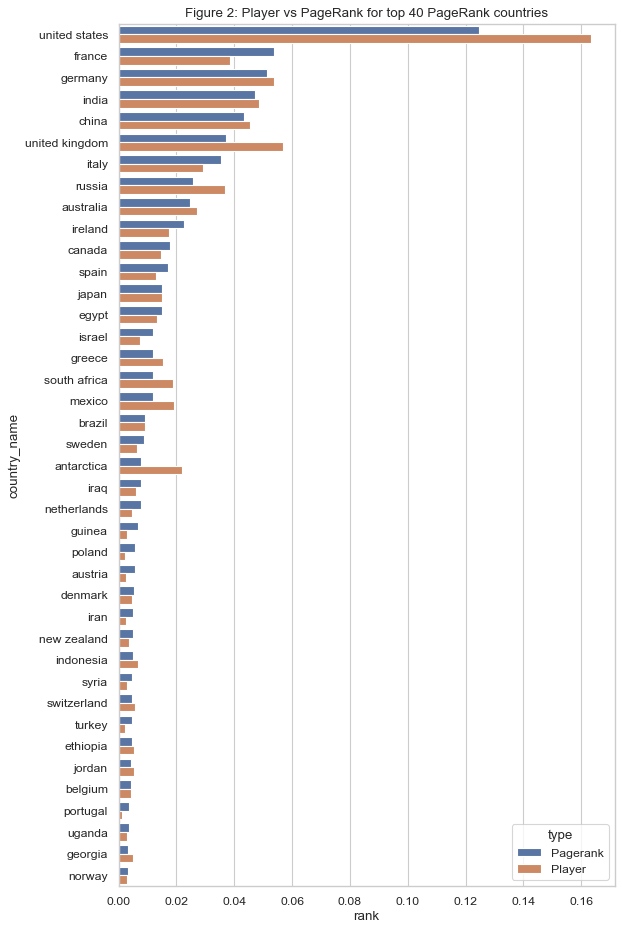

In [77]:
top_player_vs_pagerank_country_frequencies(df_player_frequencies, df_pagerank)

The differences are smaller when we aggregate per country, but again, we still see a bias towards western countries (mostly english speaking countries, actually!).

### Computing rank difference
To investigate further, we will compute the difference between the players rank and the pageranks. Here the difference $d_a$ is defined as:
$$ d_a = r_a - \mathtt{PageRank}_a $$
That way, when it is positive, it means the players tend to go more often to article $a$ than random walk, whereas when it is negative, it means players tend to go less often to article $a$ than random walk.

In [78]:
rank_v_freq_2_columns = pd.merge(df_pagerank[['article_name', 'rank']], df_player_frequencies[['article_name', 'country_name', 'rank']], on='article_name', suffixes=('_pagerank', '_players'), how='right')
rank_v_freq_2_columns = rank_v_freq_2_columns.fillna({'rank_pagerank': 0}) # fill missing pagerank values (those where isolated articles that were not added to the graph, they all have click_count 0 anyway and the pagerank should be 0 too)
rank_v_freq_2_columns['rank_diff'] = rank_v_freq_2_columns['rank_players'] - rank_v_freq_2_columns['rank_pagerank']
rank_v_freq_2_columns.sort_values(by='rank_pagerank', inplace=True, ignore_index=True, ascending=False)
rank_v_freq_2_columns

article_name  rank_pagerank    country_name  rank_players  \
0                 United_States       0.009566   united states      0.039272   
1                        France       0.006423          france      0.006988   
2                        Europe       0.006340          russia      0.017629   
3                United_Kingdom       0.006235  united kingdom      0.016756   
4              English_language       0.004865   united states      0.006210   
...                         ...            ...             ...           ...   
4598           Private_Peaceful       0.000000             NaN      0.000000   
4599  Lone_Wolf_%28gamebooks%29       0.000000   united states      0.000000   
4600                Suikinkutsu       0.000000           japan      0.000000   
4601  Underground_%28stories%29       0.000000           japan      0.000000   
4602                Wowpurchase       0.000000  united kingdom      0.000000   

      rank_diff  
0      0.029706  
1      0.000565  
2      0.011290  
3      0.010522  
4      0.001345  
...         ...  
4598   0.000000  
4599   0.000000  
4600   0.000000  
4601   0.000000  
4602   0.000000  

[4603 rows x 5 columns]

Again, we aggregate by country.

In [79]:
rank_v_freq_countries = rank_v_freq_2_columns.drop(columns=['article_name']).groupby('country_name', as_index=False, dropna=False).sum()
rank_v_freq_countries.sort_values(by='rank_pagerank', inplace=True, ignore_index=True, ascending=False)
rank_v_freq_countries

country_name  rank_pagerank  rank_players  rank_diff
0                 NaN       0.155270      0.189435   0.034165
1       united states       0.124624      0.163399   0.038774
2              france       0.053814      0.038494  -0.015320
3             germany       0.051304      0.053739   0.002435
4               india       0.047088      0.048482   0.001394
..                ...            ...           ...        ...
208              niue       0.000114      0.000000  -0.000114
209  pitcairn islands       0.000102      0.000013  -0.000089
210    norfolk island       0.000096      0.000013  -0.000084
211        st. martin       0.000064      0.000010  -0.000055
212     bouvet island       0.000053      0.000000  -0.000053

[213 rows x 4 columns]

Let us see how the difference looks like further in the articles list. To do that, we plot the PageRanks and players ranks for all articles, sorted by PageRank. For comparison, we do the same with country aggregates.

Note: here `NaN` represents articles with no linked countries. We see that they make up for about 15% of the PageRank! However those articles are discarded in our analysis since we concentrate on Western cultural biases.

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(20)
ax1.set_title('Player rank vs PageRank frequencies by articles')
rank_v_freq_2_columns.plot(x='article_name', y='rank_players', ax=ax1)
rank_v_freq_2_columns.plot(x='article_name', y='rank_pagerank', ax=ax1)

ax2.set_title('Player rank vs PageRank by countries')
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_players', ax=ax2)
rank_v_freq_countries.dropna().plot(x='country_name', y='rank_pagerank', ax=ax2)
plt.suptitle("Figure 3")

Text(0.5, 0.98, 'Figure 3')

Here we can very clearly see the impact of aggregating by country: it reduces the variance of the difference by summing over all articles from a given country. We will thus focus on analyzing the difference on a country basis as it is a more stable metric. Also, obviously, since we want to detect bias towards certain countries, it makes more sense to aggregate by country.

### High difference countries
Now we will have a look at which countries have the highest difference with respect to PageRank. To do this we sort the differences aggregated by countries from higher to lower values, and then analyze the countries with the highest positive difference (players tend to go more often to them than random walk), and highest negative difference (players tend to go less often to them than random walk)

In [81]:
rank_v_freq_by_diff = rank_v_freq_countries.dropna().sort_values(by='rank_diff', ascending=False)
rank_v_freq_by_diff

country_name  rank_pagerank  rank_players  rank_diff
1    united states       0.124624      0.163399   0.038774
6   united kingdom       0.037278      0.057000   0.019722
21      antarctica       0.007732      0.021801   0.014069
8           russia       0.025858      0.036805   0.010947
18          mexico       0.011825      0.019179   0.007354
..             ...            ...           ...        ...
12           spain       0.016984      0.012893  -0.004091
15          israel       0.012014      0.007448  -0.004566
10         ireland       0.022564      0.017547  -0.005017
7            italy       0.035398      0.029221  -0.006178
2           france       0.053814      0.038494  -0.015320

[212 rows x 4 columns]

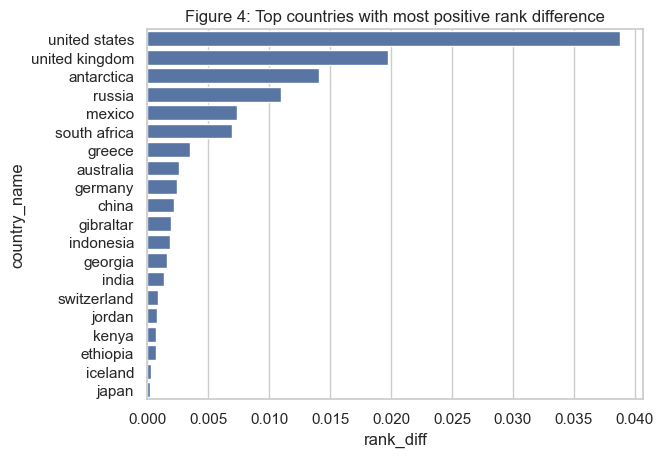

In [82]:
sns.barplot(rank_v_freq_by_diff.head(20), y='country_name', x='rank_diff', orient='y')
plt.title("Figure 4: Top countries with most positive rank difference")
plt.show()

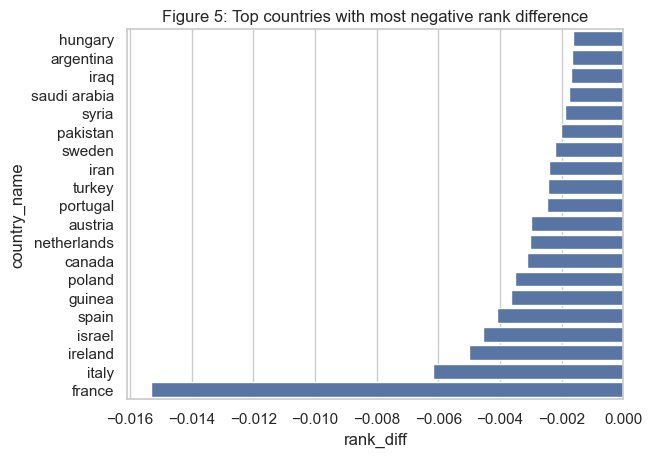

In [83]:
sns.barplot(rank_v_freq_by_diff.tail(20), y='country_name', x='rank_diff', orient='y')
plt.title("Figure 5: Top countries with most negative rank difference")
plt.show()

These results seem to indicate a bias towards english speaking countries: USA and UK have the highest positive difference. Note that this is different from a bias towards Western countries! As we can see, a lot of Western countries have high negative difference, meaning players travel less often to them than random walk (France for example).

### Statistical significance
Lastly, to make sure our conclusions are valid, let us see if the difference in the players behavior is statistically significant. To do that, we compute a chi-square test with the null hypothesis that players rank and PageRank come from the same multinomial distribution. The number of trials (parameter $n$ of the distribution) is set to the total number of clicks in the game.

In [84]:
from scipy.stats import chisquare
# p-value for significance of divergence in distribution
total_number_of_clicks = df_clicks['click_count'].sum()
chisquare(rank_v_freq_countries['rank_players'] * total_number_of_clicks, rank_v_freq_countries['rank_pagerank'] * total_number_of_clicks)

Power_divergenceResult(statistic=48887.85720332593, pvalue=0.0)

Given that the p-value is very close to 0 (floating point has approximated it to 0), we can conclude that the players behave significantly differently than a random walk. Although they are not particularly biased towards all Western countries, they seem to be biased toward english speaking countries.

## 3.4. Is there something inherent to the way players play the game?


As we already saw in 2.1, biases in the number of articles per country greatly influence the click counts and thus the metric that we use to evaluate the behavior of players. This initial insight already suggests that players' behavior is influenced by the graph structure. Adding to that was part 3.1 which showed that the start and target articles, that are not chosen by players but counted in the click counts, are also biased towards certain countries (mostly USA and UK). Again, this suggests that our metric for player behavior is influenced by the graph structure. This point is again shown in 3.2, where we saw that 62% of the click count variance could be explained by the in-degree and out-degree of articles. But can the behavior of players be completely explained by the graph structure? No: as seen in part 3.3, which tried to answer this question by comparing the players' clicking behavior with PageRank, even when removing as much of the influence of the graph as possible, there is still a significant bias of the players. However, this bias seems to be towards English speaking countries specifically as opposed to Western countries in general. This is expected: the game is in English and thus probably attracts more English speaking players, which tend to visit articles about English speaking countries more often. Thus, although the graph structure greatly influences the behavior of the players, there is still a significant bias in the player themselves. However, this bias does not seem to be towards all Western countries, but specifically towards English speaking countries.